#  **Modeling the problem as an Integer Problem** 



## **Integer problem** 

$$
\begin{align*}
\underset{\hspace{0.05cm} \mathbf{t} \hspace{0.05cm} }{Max}  & \quad  \sum_{j=1}^{p} \sum_{i=1}^{n} \hspace{0.1cm}t_{ij}\cdot w_j\\[0.5cm]
\text{s.t.:}&\\[0.2cm]
  & \sum_{j=1}^p t_{ij} \hspace{0.05cm}\leq\hspace{0.05cm} h_1 \hspace{0.1cm},\hspace{0.15cm} \forall i = 1,\dots,n\\[0.5cm]
  &t_{ij} \hspace{0.05cm}\geq\hspace{0.05cm} h_2\hspace{0.1cm},\hspace{0.15cm} \forall i = 1,\dots,n\hspace{0.1cm},\hspace{0.15cm}  \forall j = 1,\dots,p\\[0.3cm]
  &\sum_{i=1}^n t_{ij} \hspace{0.05cm}\geq\hspace{0.05cm} h_3(w_j) \hspace{0.1cm},\hspace{0.15cm} \forall j = 1,\dots, p \\[0.5cm]
  &\sum_{i=1}^n t_{ij} \hspace{0.05cm}\leq\hspace{0.05cm} h_4  \hspace{0.1cm},\hspace{0.15cm} \forall j = 1,\dots, p \\[0.5cm] 
  & t_{ij} \hspace{0.05cm}\geq\hspace{0.05cm} 0 \hspace{0.1cm},\hspace{0.15cm} \forall i =1,\dots,n \hspace{0.1cm},\hspace{0.15cm} \forall j =1,\dots,p\\[0.5cm]
    & \sum_{j=1}^p y_{j} \hspace{0.05cm} = \hspace{0.05cm} p \hspace{0.25cm}\text{(new constraint)} \\[0.5cm]
\end{align*}
$$

Where:

$$y_j = \begin{cases}
1, \hspace{0.2cm} \sum_{i=1}^n t_{ij} > 0 \\[0.2cm]
0, \hspace{0.2cm}  \sum_{i=1}^n t_{ij} = 0
\end{cases}
$$

Which is equivalent to:

$$y_j\cdot \varepsilon \hspace{0.1cm} \leq \hspace{0.1cm} \sum_{i=1}^n t_{ij}  \hspace{0.1cm}\leq \hspace{0.1cm} y_j \cdot M$$

being $\varepsilon$ and $M$ a small and large enough positive constant, respectively.

**Observation:**

If $\hspace{0.1cm} h_3^{ij} > 0, \hspace{0.05cm}\forall\hspace{0.05cm}\scriptsize{ i,j = (1,2), (3,4),\dots, (9,10)}$,  the new constraint will not make any impact in the problem, just because if $h_3^{12} > 0$, all the patients are seen, when the problem is feasible.

So, in order to see the effect of the new constraint we have to set $\hspace{0.1cm}h_3^{ij} = 0, \hspace{0.05cm}\exists\hspace{0.05cm}\scriptsize{ i,j = (1,2), (3,4),\dots, (9,10)}$.


## **Solving with `Pyomo`** 

First of all, we are going to implement the general integer (binary) problem presented above in `Pyomo`. 

In [131]:
def hospital_integer_model(n, p, w, h1, h2, h3_1_2, h3_3_4, h3_5_6, h3_7_8, h3_9_10, h4):
    """
    Implements and solves the hospital integer (binary) model.

    Parameters (inputs)
    ----------
    n: number of nurse-doctor tandems in a given day.
    p: number of patients tandems in a given day.
    w: 1-D array with the severity/importance of the patients.
    h1: maximum time seeing patients per nurse-doctor tandem in a given day.
    h2: maximum time spent by nurse-doctor tandem i seeing the patient j, for all i,j.
    h3_1_2: minimum time time spent in patient j, if w[j] in [1,2].
    h3_3_4: minimum time time spent in patient j, if w[j] in [3,4].
    h3_5_6: minimum time time spent in patient j, if w[j] in [5,6].
    h3_7_8: minimum time time spent in patient j, if w[j] in [7,8].
    h3_9_10: minimum time time spent in patient j, if w[j] in [9,10].
    h4: maximum time time spent in patient j.

    Returns (outputs)
    -------
    model: the Pyomo model output.
    t_optimal: a dictionary with the optimal values for the t_ij decision variables.
    y_optimal: a dictionary with the optimal values for the y_j decision variables.
    f_optimal: the optimal value of the objective function.
    """

    # Defining h3 function.
    def h3(w):
        if w in [1, 2] :
           return h3_1_2
        if w in [3, 4] :
           return h3_3_4
        elif w in [5, 6] :
           return h3_5_6
        elif w in [7, 8] :
           return h3_7_8
        elif w in [9, 10] :
           return h3_9_10

    # Initialize a model.
    model = ConcreteModel()

    # Initialize ranges for tandems and patients.
    model.N = range(0,n)
    model.P = range(0,p)

    # Defining t_ij decision variables as non-negative reals (t_ij >= 0).
    model.t = Var(model.N, model.P, domain=NonNegativeReals) 

    # Defining y_j as a binary variable (y_j in {0,1}).
    model.y = Var(model.P, domain=Binary)

    # Objective function to maximize the weighted sum of time spent with patients
    model.cost = Objective(expr=sum(model.t[i,j] * w[j] for i in model.N for j in model.P), sense=maximize)

    # Constraints
    model.constraints = ConstraintList()

    # The total time spent by each tandem on all patients must be at most h1.
    for i in model.N:
        model.constraints.add(sum(model.t[i,j] for j in model.P) <= h1)

    # The time spent by tandem i on patient j must be at most h2.
    for i in model.N:
        for j in model.P:
            model.constraints.add(model.t[i, j] <= h2)
    
    # The total time a patient is seen by all tandems must be at least h3(w[j])
    for j in model.P:
        model.constraints.add(sum(model.t[i,j] for i in model.N) >= h3(w[j]))

    # The total time a patient is seen by all tandems must be at most h4.
    for j in model.P:
        model.constraints.add(sum(model.t[i,j] for i in model.N) <= h4)

    # y[j] is 1 if sum(model.t[i,j] for i in model.N) > 0.
    M = 1000000
    for j in model.P:
        model.constraints.add(sum(model.t[i,j] for i in model.N) <= model.y[j] * M)
         
    # y[j] is 0 if sum(model.t[i,j] for i in model.N) = 0
    epsilon = 0.000001
    for j in model.P:
        model.constraints.add(epsilon * model.y[j] <= sum(model.t[i,j] for i in model.N))

    # The number of patients seen (sum(model.y[j] for j in model.P)) must be equal to the number of patients (p).
    model.constraints.add(sum(model.y[j] for j in model.P) == p)

    # Load dual information
    # model.dual = Suffix(direction=Suffix.IMPORT)

    # Solve the model
    solver = SolverFactory('glpk')
    results = solver.solve(model, tee=False)  # Set tee=True to show solver output

    # Check solver status and termination condition
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #print("Solution Found")
        # Extract optimal values for variables and objective
        t_optimal = {(i, j): model.t[i, j].value for i in model.N for j in model.P}
        y_optimal = {j: model.y[j].value for j in model.P}
        f_optimal = model.cost.expr()
    elif results.solver.termination_condition == TerminationCondition.infeasible:
        #print("No feasible solution")
        t_optimal, y_optimal, f_optimal = None, None, None
    else:
        #print("No feasible solution")
        t_optimal, y_optimal, f_optimal = None, None, None

    return model, t_optimal, y_optimal, f_optimal

## **Preliminary analysis**

In this section we are going to do a preliminary numerical analysis of the problem posed above, for a given set of parameters.

In [132]:
# Parameters definition:
n=50; p=500; h1=6; h2=1; h4=4

h3_1_2 = 0
h3_3_4 = 0.30 
h3_5_6 = 0.55  
h3_7_8 = 0.80 
h3_9_10 = 1 
    
np.random.seed(123)
w = np.random.randint(1, 11, p) 

# Problem execution:
model, t_optimal, y_optimal, f_optimal = hospital_integer_model(n, p, w, h1, h2, h3_1_2, h3_3_4, h3_5_6, h3_7_8, h3_9_10, h4)

#### **Optimal values**

 **Decision variables**

The optimal values for the $t_{ij}$ decision variables for the given set of parameters are the following:

In [133]:
t_optimal

{(0, 0): 0.0,
 (0, 1): 0.0,
 (0, 2): 0.0,
 (0, 3): 0.0,
 (0, 4): 0.0,
 (0, 5): 0.0,
 (0, 6): 0.0,
 (0, 7): 0.0,
 (0, 8): 0.0,
 (0, 9): 0.0,
 (0, 10): 0.0,
 (0, 11): 0.0,
 (0, 12): 0.0,
 (0, 13): 0.0,
 (0, 14): 0.0,
 (0, 15): 0.0,
 (0, 16): 0.0,
 (0, 17): 0.0,
 (0, 18): 0.0,
 (0, 19): 0.0,
 (0, 20): 0.0,
 (0, 21): 0.0,
 (0, 22): 0.0,
 (0, 23): 0.0,
 (0, 24): 0.0,
 (0, 25): 0.0,
 (0, 26): 0.0,
 (0, 27): 0.0,
 (0, 28): 0.0,
 (0, 29): 0.0,
 (0, 30): 0.0,
 (0, 31): 0.0,
 (0, 32): 0.0,
 (0, 33): 0.0,
 (0, 34): 0.0,
 (0, 35): 0.0,
 (0, 36): 0.0,
 (0, 37): 0.0,
 (0, 38): 0.0,
 (0, 39): 0.0,
 (0, 40): 0.0,
 (0, 41): 0.0,
 (0, 42): 0.0,
 (0, 43): 0.0,
 (0, 44): 0.0,
 (0, 45): 0.0,
 (0, 46): 0.0,
 (0, 47): 0.0,
 (0, 48): 0.0,
 (0, 49): 0.0,
 (0, 50): 0.0,
 (0, 51): 0.0,
 (0, 52): 0.0,
 (0, 53): 0.0,
 (0, 54): 0.0,
 (0, 55): 0.0,
 (0, 56): 0.0,
 (0, 57): 0.0,
 (0, 58): 0.0,
 (0, 59): 0.0,
 (0, 60): 0.0,
 (0, 61): 0.0,
 (0, 62): 0.0,
 (0, 63): 0.0,
 (0, 64): 0.0,
 (0, 65): 0.0,
 (0, 66): 0.0,
 (0, 

The optimal values for the $y_{j}$ decision variables for the given set of parameters are the following:

In [134]:
y_optimal

{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 1.0,
 13: 1.0,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 1.0,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 1.0,
 24: 1.0,
 25: 1.0,
 26: 1.0,
 27: 1.0,
 28: 1.0,
 29: 1.0,
 30: 1.0,
 31: 1.0,
 32: 1.0,
 33: 1.0,
 34: 1.0,
 35: 1.0,
 36: 1.0,
 37: 1.0,
 38: 1.0,
 39: 1.0,
 40: 1.0,
 41: 1.0,
 42: 1.0,
 43: 1.0,
 44: 1.0,
 45: 1.0,
 46: 1.0,
 47: 1.0,
 48: 1.0,
 49: 1.0,
 50: 1.0,
 51: 1.0,
 52: 1.0,
 53: 1.0,
 54: 1.0,
 55: 1.0,
 56: 1.0,
 57: 1.0,
 58: 1.0,
 59: 1.0,
 60: 1.0,
 61: 1.0,
 62: 1.0,
 63: 1.0,
 64: 1.0,
 65: 1.0,
 66: 1.0,
 67: 1.0,
 68: 1.0,
 69: 1.0,
 70: 1.0,
 71: 1.0,
 72: 1.0,
 73: 1.0,
 74: 1.0,
 75: 1.0,
 76: 1.0,
 77: 1.0,
 78: 1.0,
 79: 1.0,
 80: 1.0,
 81: 1.0,
 82: 1.0,
 83: 1.0,
 84: 1.0,
 85: 1.0,
 86: 1.0,
 87: 1.0,
 88: 1.0,
 89: 1.0,
 90: 1.0,
 91: 1.0,
 92: 1.0,
 93: 1.0,
 94: 1.0,
 95: 1.0,
 96: 1.0,
 97: 1.0,
 98: 1.0,
 99: 1.0,
 100: 1.0,

For example, the time spent in patient $j=5$ by tandem $i=1$, i.e. $t_{15}$, is:

In [135]:
t_optimal[0,4] # 0 h

0.0

**Objective function**

In this case the optimal value for the objective function is the following:

In [136]:
f_optimal

2316.5991200000026

#### **Time spent in patients**

Now we are going to analyze the time spent in the patients, in this particular case.

We built a function that computes the time spent seeing patient j in a given day .
It's important to notice that a patient could be seen by several nurse-doctor tandems.

In [137]:
# Time spent seeing patient j in a given day (he could be seen by several nurse-doctor tandems).
def time_seeing_patient(j):
    return np.sum([t_optimal[i, j] for i in range(0,n)])

For example, total time spent in patient $j=45$, that is, $\sum_{i=1}^n t_{i45}$, is the following:

In [138]:
time_seeing_patient(44)

0.8

Using the previous function we can collect the total time spent in each patient in an array.

In [139]:
total_times_per_patient = np.array([time_seeing_patient(j) for j in range(0,p)])

In [140]:
total_times_per_patient

array([3.000000e-01, 3.000000e-01, 8.000000e-01, 1.000000e-06,
       3.000000e-01, 1.000000e+00, 8.000000e-01, 1.000000e-06,
       1.000000e-06, 1.000000e-06, 1.000000e+00, 1.000000e-06,
       1.000000e-06, 1.000000e+00, 3.000000e-01, 5.500000e-01,
       1.000000e-06, 1.000000e-06, 5.500000e-01, 1.000000e-06,
       8.000000e-01, 3.000000e-01, 3.000000e-01, 5.500000e-01,
       8.000000e-01, 3.000000e-01, 5.500000e-01, 1.000000e+00,
       1.000000e-06, 8.000000e-01, 1.000000e+00, 3.000000e-01,
       5.500000e-01, 8.000000e-01, 1.000000e-06, 5.500000e-01,
       8.000000e-01, 3.000000e-01, 1.000000e-06, 1.000000e+00,
       3.000000e-01, 5.500000e-01, 1.000000e-06, 3.000000e-01,
       8.000000e-01, 3.000000e-01, 5.500000e-01, 5.500000e-01,
       8.000000e-01, 3.000000e-01, 1.000000e-06, 8.000000e-01,
       5.500000e-01, 8.000000e-01, 8.000000e-01, 8.000000e-01,
       1.000000e-06, 5.500000e-01, 8.000000e-01, 1.000000e+00,
       3.000000e-01, 5.500000e-01, 1.000000e+00, 1.0000

#### **Average time spent per patient**

Now we can compute some statistics over the time spent in patients, like for example the average time spent per patient.

In [141]:
np.mean(total_times_per_patient)

0.6

#### **Max time spent per patient**

The maximum time spent in a single patient is enforced by $h_4$ constriant, that in this case has been fixed to $4$.

In [142]:
np.max(total_times_per_patient) # 4 hours

4.000000000000004

#### **Min time spent per patient**

The minimun time spent in a single patient is set by $h_3^{12}$, in this case, that has been fixed to $0.1$.

In [143]:
np.min(total_times_per_patient) 

1e-06

#### **Median of time spent per patient**

In [144]:
np.median(total_times_per_patient) 

0.55

#### **$75$-quantile of time spent per patient**

In [145]:
np.quantile(total_times_per_patient, 0.75)

0.8

#### **$25$-quantile time spent per patient**

In [146]:
np.quantile(total_times_per_patient, 0.25)

0.3

#### **Number of patients seen**

Another interesting statistic to compute is the number of patients seen. This can be calculated as the number of non zero values in the array `total_times_per_patient`.

The number of patients seen is $p=500$ even though we have set $h_3^{12}=0$, so the new constraint is working well. In addition, we can see as the number of patient seen match with $\sum_{j=1}^p y_j$, which is something that must always be fulfilled in this new version of the problem.

In [147]:
np.sum(total_times_per_patient > 0)

500

In [148]:
np.sum(list(y_optimal.values()))

500.0

#### **Relation between total time per patients and theis severity/importance $(w)$**

We can do a simple analysis of the relationship between the time spent per patient and the severity/importance of the patient. 

For example, we can compute the Pearson linear correlation coefficient between this two variables.

In [149]:
pearsonr(w, total_times_per_patient)

PearsonRResult(statistic=0.7226412439587873, pvalue=6.657899664357222e-82)

A linear correlation of $0.74$ indicates a high positive linear relationship between the time spent per patient and their severity/importance.

We can make an scatter plot of both variables to visualize this relationship.

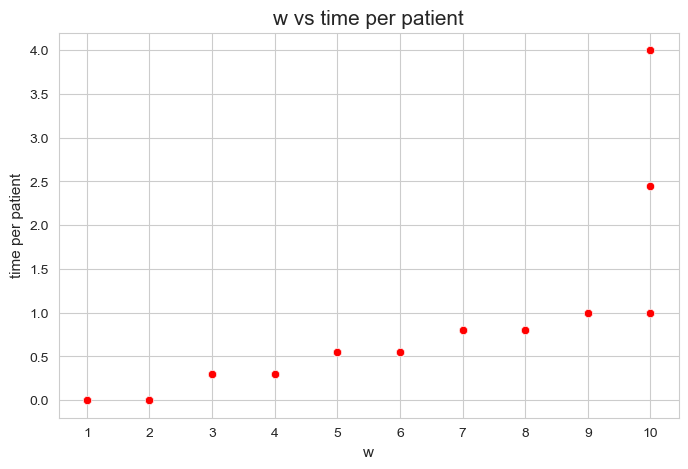

In [150]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(x=w, y=total_times_per_patient, color='red')
plt.title('w vs time per patient', size=15)
ax.set_ylabel('time per patient', size=11)
ax.set_xlabel('w', size=11)
plt.xticks(np.unique(w))
plt.show()

It's important to realize that the points are overlapped, since there are $500$ patients and only $13$ points are visible.

## **Analysis of sensitivity** 

### **Analysis of individual parameters** 

In this section we make a sensitivity analysis of some of the parameters of the problem, following an individual approach, in the sense that each parameter will be analyzed separately.

This analysis is essentially carried out using the functions `get_results1` and `get_results2`.

##### **Analysis of $h_1$ parameter**

   - $h_1 :=$ maximum time seeing patients per nurse-doctor tandem in a given day.


In [151]:
# Defining the values of the rest of parameters and setting h1 as None.
params['n'] = 50 ; params['p']=500 ; params['h1']=None ; params['h2']=1 ; params['h4']=4
params['h3_1_2'] = 0
params['h3_3_4'] = 0.30 
params['h3_5_6'] = 0.55  
params['h3_7_8'] = 0.80 
params['h3_9_10'] = 1 

np.random.seed(123)
params['w'] = np.random.randint(1, 11, params['p']) 

# Defining the parameter values list.
parameter_list = np.arange(2, 13)

Now we are going to use te results stored in `results1_IM` and `results2_IM` to make some valuable plots, in order to analyze the influence of the $h_1$ parameter in the hospital integer (binary) model.

In [152]:
results1 = get_results1('h1', parameter_list, params, model='integer')

In [153]:
results2 = get_results2('h1', parameter_list, results1)

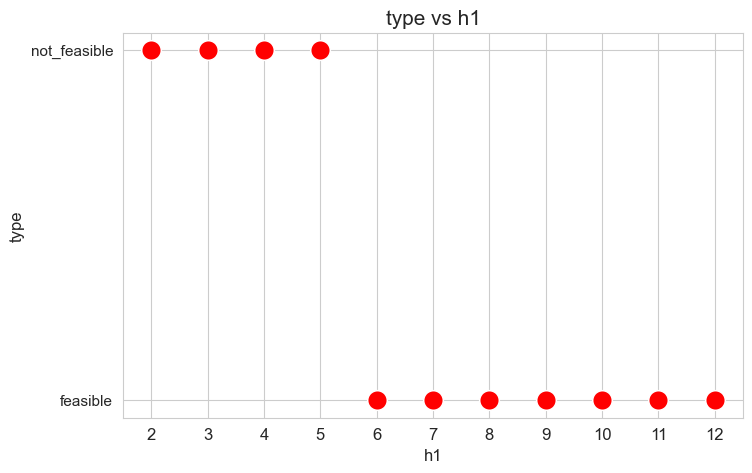

In [154]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(y=results2['h1']['type'], x=parameter_list, color='red', s=200)
plt.title('type vs h1', size=15)
ax.set_ylabel('type', size=12)
ax.set_xlabel('h1', size=12)
plt.xticks(parameter_list, fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Number of patients seen vs $h_1$**

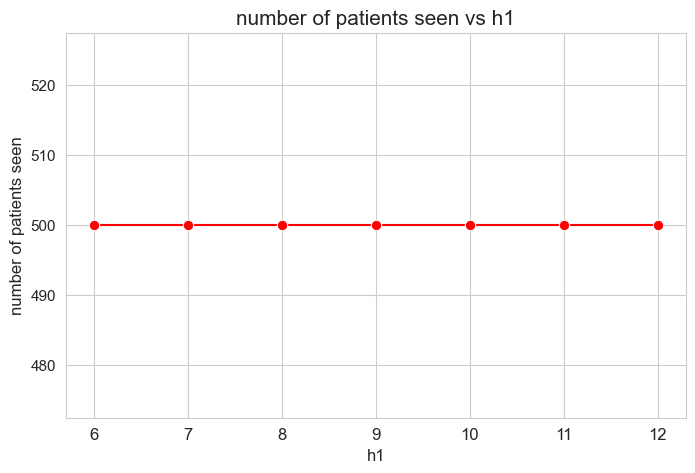

In [155]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h1']['num_patients_seen'].values(), x=results2['h1']['feasible'], 
                  marker='o', markersize=7.5, color='red')
plt.title('number of patients seen vs h1', size=15)
ax.set_ylabel('number of patients seen', size=12)
ax.set_xlabel('h1', size=12)
plt.xticks(results2['h1']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

In this case is not trivial that the number of patients seen is the maximum possible $(=p)$, since $h_3^{12}=0$ unlike the analogous analysis performed with the linear model. This indicates that the new binary variable and the new constraint are working well.

- **Optimal value of the objective function vs $h_1$**

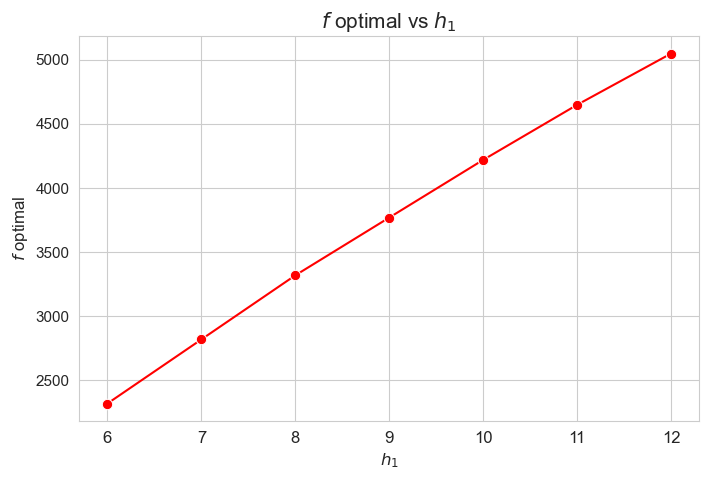

In [156]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h1']['f_optimal_feasible'].values(), x=results2['h1']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('$f$ optimal vs $h_1$', size=15)
ax.set_ylabel('$f$ optimal', size=12)
ax.set_xlabel('$h_1$', size=12)
plt.xticks(results2['h1']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $h_1$**

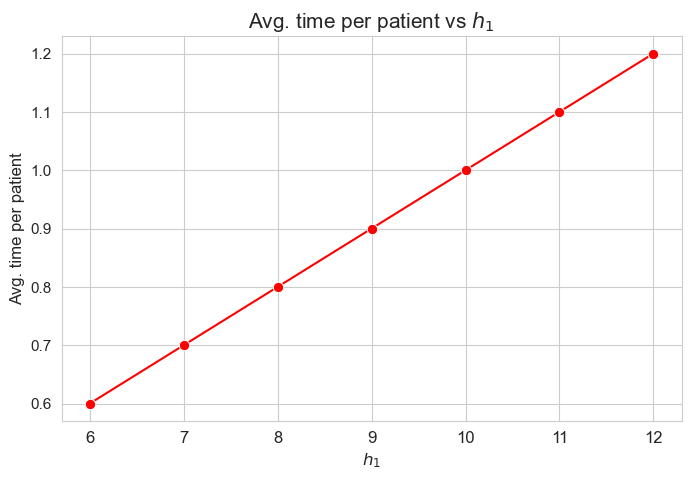

In [157]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h1']['avg_time_per_patient'].values(), x=results2['h1']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Avg. time per patient vs $h_1$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$h_1$', size=12)
plt.xticks(results2['h1']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Median time spent per patient vs $h_1$**

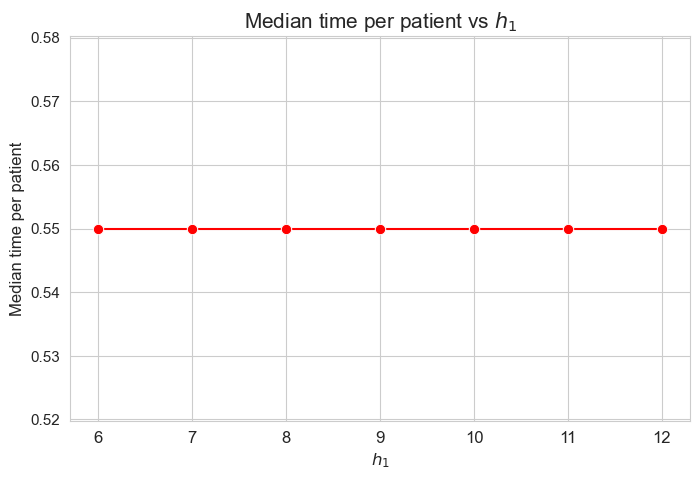

In [158]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h1']['median_time_per_patient'].values(), x=results2['h1']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Median time per patient vs $h_1$', size=15)
ax.set_ylabel('Median time per patient', size=12)
ax.set_xlabel('$h_1$', size=12)
plt.xticks(results2['h1']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$75$-quantile time spent per patient vs $h_1$**

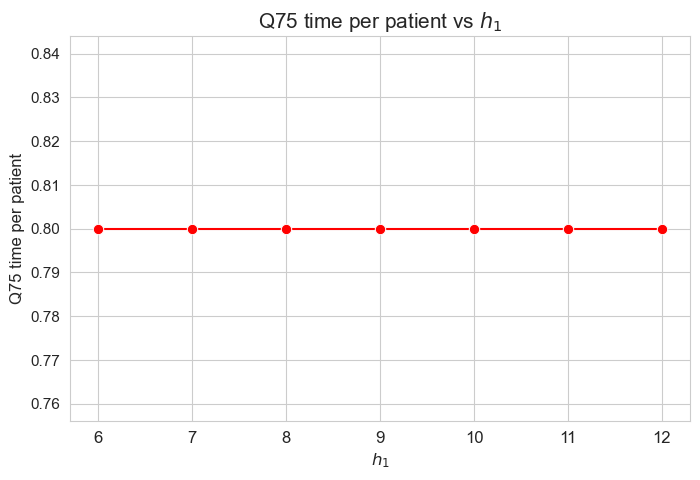

In [159]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h1']['Q75_time_per_patient'].values(), x=results2['h1']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q75 time per patient vs $h_1$', size=15)
ax.set_ylabel('Q75 time per patient', size=12)
ax.set_xlabel('$h_1$', size=12)
plt.xticks(results2['h1']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$25$-quantile time spent per patient vs $h_1$**

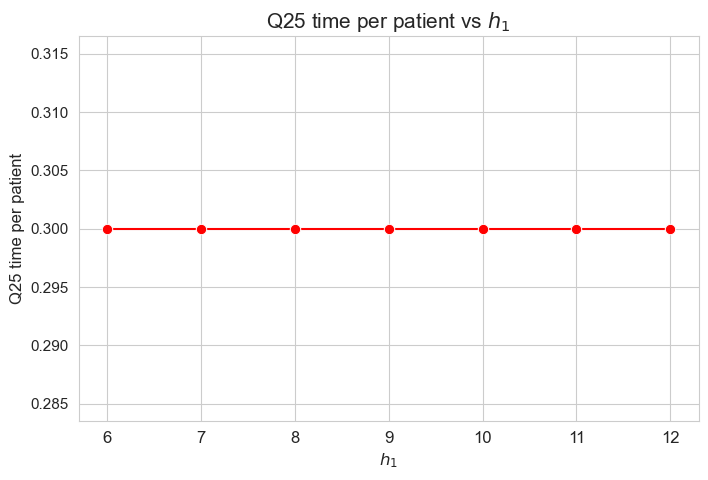

In [160]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h1']['Q25_time_per_patient'].values(), x=results2['h1']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q25 time per patient vs $h_1$', size=15)
ax.set_ylabel('Q25 time per patient', size=12)
ax.set_xlabel('$h_1$', size=12)
plt.xticks(results2['h1']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $w$ vs $h_1$**

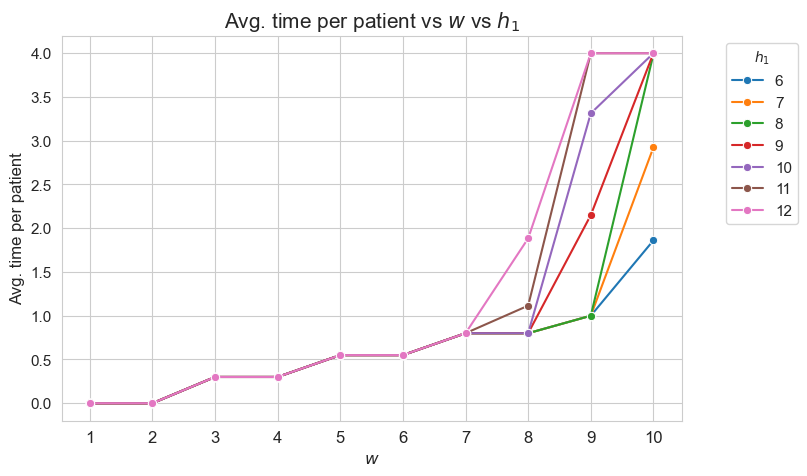

In [161]:
plt.figure(figsize=(8, 5))
for i, h1 in zip(results2['h1']['avg_time_patient_per_w'].keys(), results2['h1']['feasible']) :
    ax = sns.lineplot(y=results2['h1']['avg_time_patient_per_w'][i].values(), x=results2['h1']['avg_time_patient_per_w'][i].keys(), 
                      label=h1, marker='o', markersize=6)
plt.title('Avg. time per patient vs $w$ vs $h_1$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$w$', size=12)
plt.xticks(list(results2['h1']['avg_time_patient_per_w'][i].keys()), fontsize=12)
plt.yticks(fontsize=11)
plt.legend(title='$h_1$', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

##### **Analysis of $h_2$ parameter**

   - $h_2 :=$ maximum time spent by nurse-doctor tandem $i$ seeing the patient $j$, for all $i,j$.


In [162]:
params['n'] = 50 ; params['p']=500 ; params['h1']=6 ; params['h2']=None ; params['h4']=4
params['h3_1_2'] = 0
params['h3_3_4'] = 0.30 
params['h3_5_6'] = 0.55  
params['h3_7_8'] = 0.80 
params['h3_9_10'] = 1 

np.random.seed(123)
params['w'] = np.random.randint(1, 11, params['p']) 

parameter_list = np.round(np.arange(0.4, 2.2, 0.2), 2)

In [163]:
results1 = get_results1('h2', parameter_list, params, model='integer')

In [164]:
results2 = get_results2('h2', parameter_list, results1)

- **Problem type (feasible - not feasible) vs $h_2$**

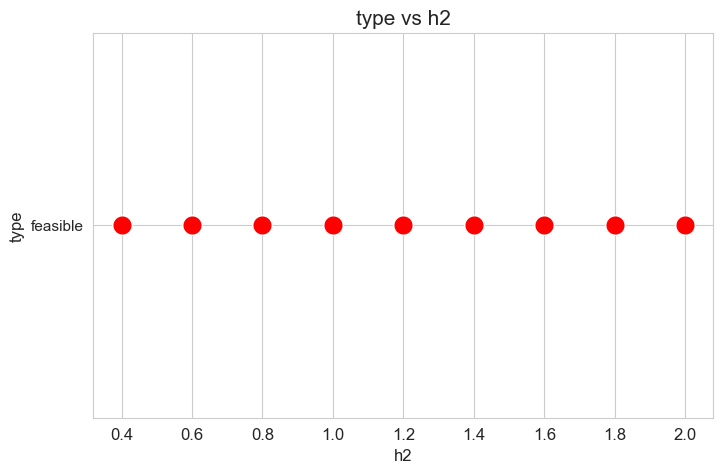

In [165]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(y=results2['h2']['type'], x=parameter_list, color='red', s=200)
plt.title('type vs h2', size=15)
ax.set_ylabel('type', size=12)
ax.set_xlabel('h2', size=12)
plt.xticks(parameter_list, fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Number of patients seen vs $h_2$**

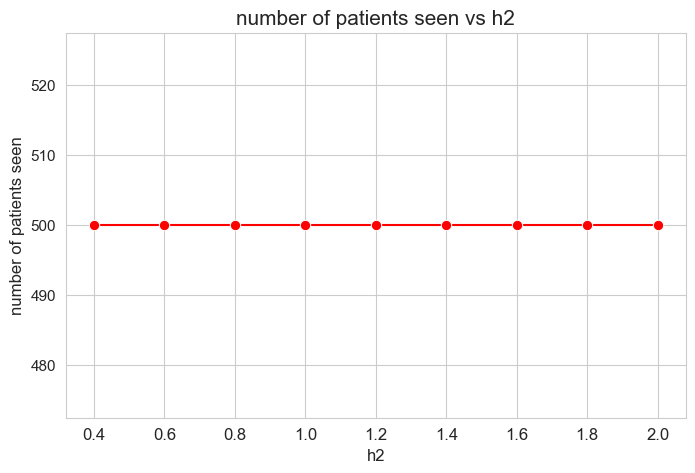

In [166]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h2']['num_patients_seen'].values(), x=results2['h2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('number of patients seen vs h2', size=15)
ax.set_ylabel('number of patients seen', size=12)
ax.set_xlabel('h2', size=12)
plt.xticks(results2['h2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for $h_1$.

- **Optimal value of the objective function vs $h_2$**

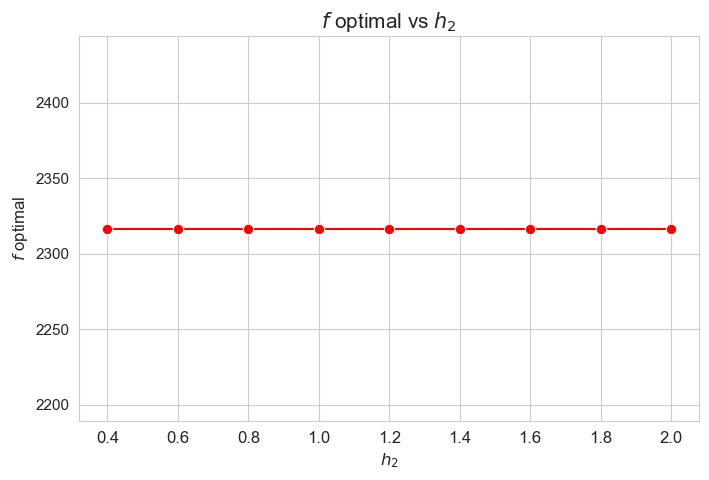

In [167]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=np.round(list(results2['h2']['f_optimal_feasible'].values()), 3), x=results2['h2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('$f$ optimal vs $h_2$', size=15)
ax.set_ylabel('$f$ optimal', size=12)
ax.set_xlabel('$h_2$', size=12)
plt.xticks(results2['h2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $h_2$**

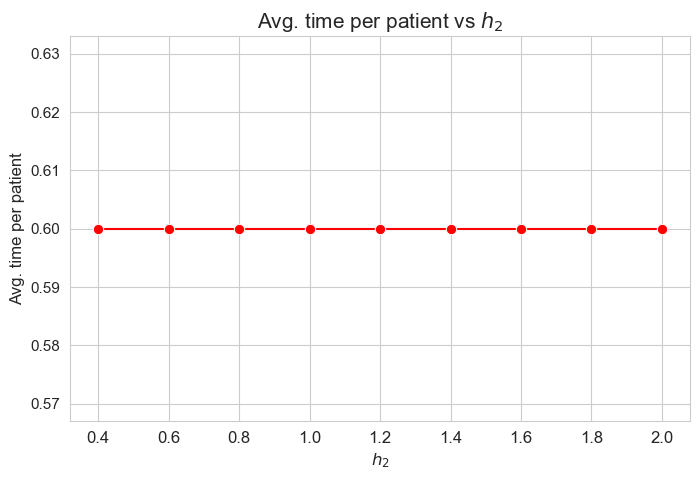

In [168]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h2']['avg_time_per_patient'].values(), x=results2['h2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Avg. time per patient vs $h_2$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$h_2$', size=12)
plt.xticks(results2['h2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Median time spent per patient vs $h_2$**

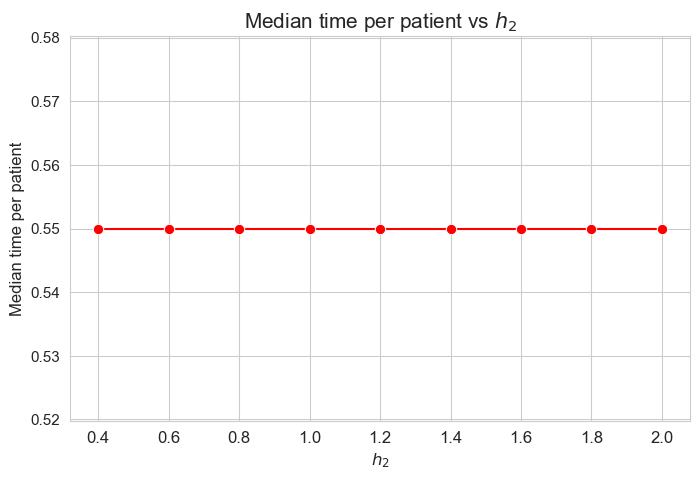

In [169]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h2']['median_time_per_patient'].values(), x=results2['h2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Median time per patient vs $h_2$', size=15)
ax.set_ylabel('Median time per patient', size=12)
ax.set_xlabel('$h_2$', size=12)
plt.xticks(results2['h2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$75$-quantile of time spent per patient vs $h_2$**

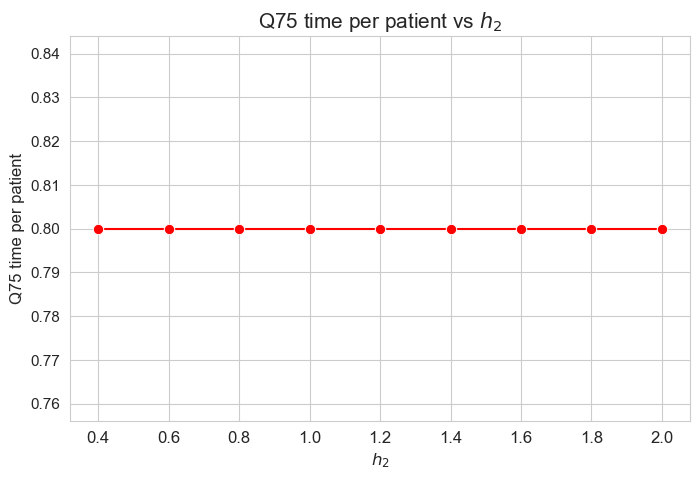

In [170]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h2']['Q75_time_per_patient'].values(), x=results2['h2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q75 time per patient vs $h_2$', size=15)
ax.set_ylabel('Q75 time per patient', size=12)
ax.set_xlabel('$h_2$', size=12)
plt.xticks(results2['h2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$25$-quantile of time spent per patient vs $h_2$**

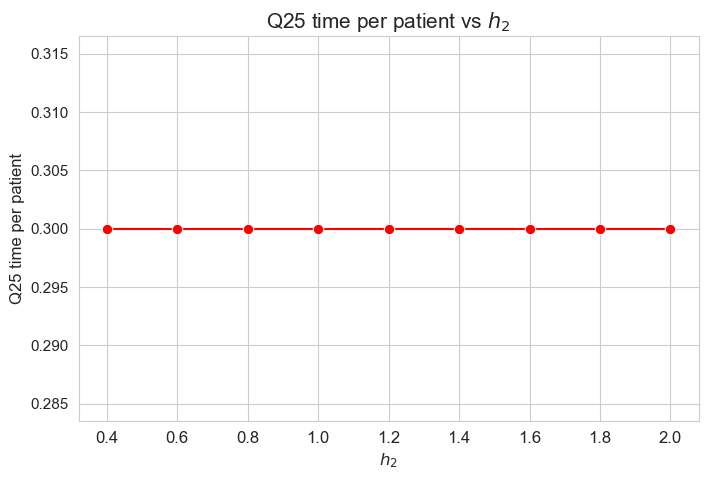

In [171]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h2']['Q25_time_per_patient'].values(), x=results2['h2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q25 time per patient vs $h_2$', size=15)
ax.set_ylabel('Q25 time per patient', size=12)
ax.set_xlabel('$h_2$', size=12)
plt.xticks(results2['h2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $w$ vs $h_2$**

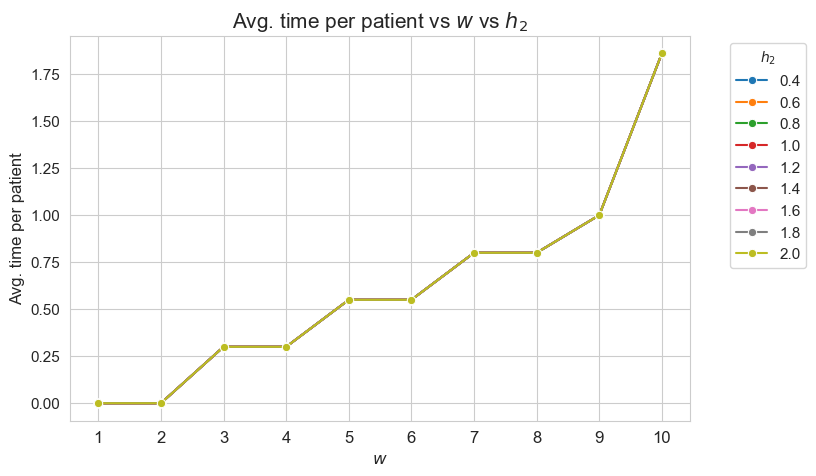

In [172]:
plt.figure(figsize=(8, 5))
for i, h2 in zip(results2['h2']['avg_time_patient_per_w'].keys(), results2['h2']['feasible']) :
    ax = sns.lineplot(y=results2['h2']['avg_time_patient_per_w'][i].values(), x=results2['h2']['avg_time_patient_per_w'][i].keys(), 
                      label=h2, marker='o', markersize=6)
plt.title('Avg. time per patient vs $w$ vs $h_2$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$w$', size=12)
plt.xticks(list(results2['h2']['avg_time_patient_per_w'][i].keys()), fontsize=12)
plt.yticks(fontsize=11)
plt.legend(title='$h_2$', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

##### **Analysis of $h_3$ parameter**

$h_3 :=$  minimum time time spent in each patient, taking into account their severity/importance (this quantity depends on $w_j$).


##### **$h_3^{12}$ parameter**

$h_3^{12} :=$  minimum time time spent in patients with $w_j \in \lbrace 1, 2 \rbrace$

In [173]:
params['n'] = 50 ; params['p']=500 ; params['h1']=6 ; params['h2']=1 ; params['h4']=4
params['h3_1_2'] = None 
params['h3_3_4'] = 0.30 
params['h3_5_6'] = 0.55  
params['h3_7_8'] = 0.80 
params['h3_9_10'] = 1 

np.random.seed(123)
params['w'] = np.random.randint(1, 11, params['p']) 

parameter_list = np.arange(0, 0.50, 0.05)

In [174]:
results1 = get_results1('h3_1_2', parameter_list, params, model='integer')

In [175]:
results2 = get_results2('h3_1_2', parameter_list, results1)

- **Problem type (feasible - not feasible) vs $h_3^{12}$**

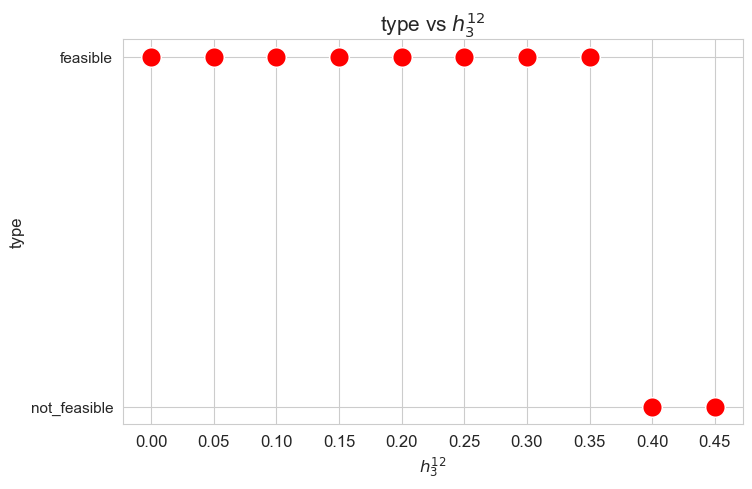

In [176]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(y=results2['h3_1_2']['type'], x=parameter_list, color='red', s=200)
plt.title('type vs $h_3^{12}$', size=15)
ax.set_ylabel('type', size=12)
ax.set_xlabel('$h_3^{12}$', size=12)
plt.xticks(parameter_list, fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Number of patients seen vs $h_3^{12}$**

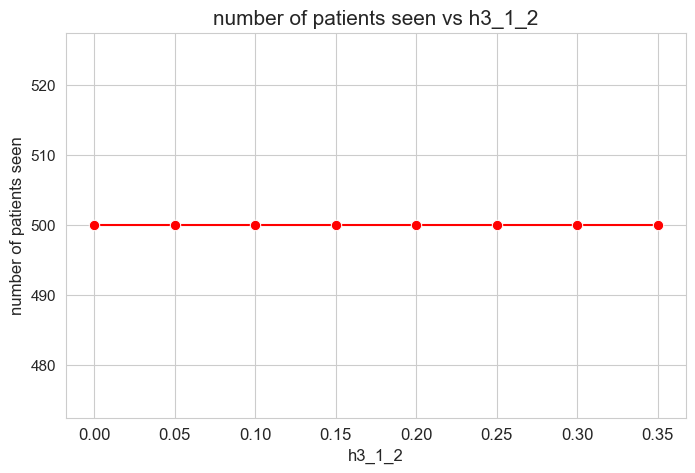

In [177]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_1_2']['num_patients_seen'].values(), x=results2['h3_1_2']['feasible'], 
                  marker='o', markersize=7.5, color='red')
plt.title('number of patients seen vs h3_1_2', size=15)
ax.set_ylabel('number of patients seen', size=12)
ax.set_xlabel('h3_1_2', size=12)
plt.xticks(results2['h3_1_2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Even when $h_3^{12}=0$, the number of patients seen is the maximum possible $(p)$, thanks to the new constraint added in the binary model.

- **Optimal value of the objective function vs $h_3^{12}$**

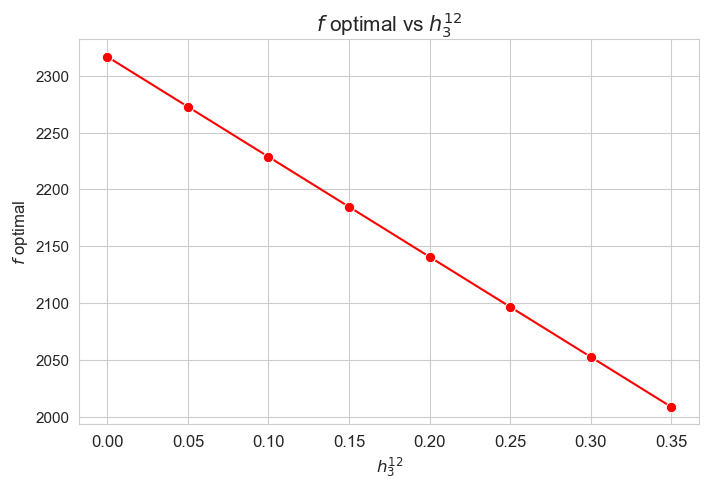

In [178]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_1_2']['f_optimal_feasible'].values(), x=results2['h3_1_2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('$f$ optimal vs $h_3^{12}$', size=15)
ax.set_ylabel('$f$ optimal', size=12)
ax.set_xlabel('$h_3^{12}$', size=12)
plt.xticks(results2['h3_1_2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $h_3^{12}$**

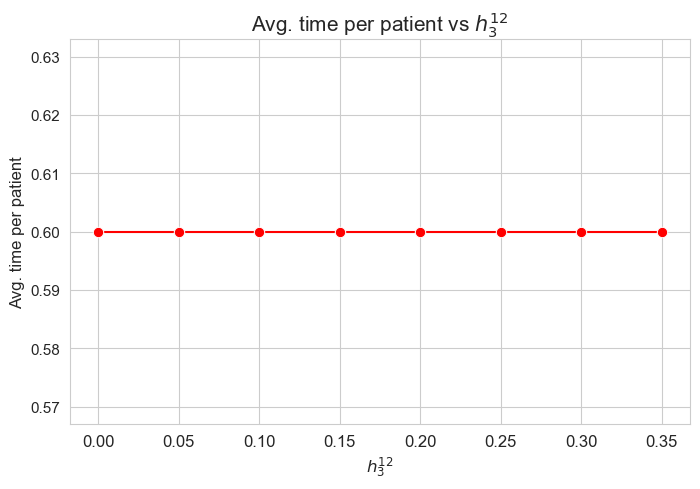

In [179]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_1_2']['avg_time_per_patient'].values(), x=results2['h3_1_2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Avg. time per patient vs $h_3^{12}$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$h_3^{12}$', size=12)
plt.xticks(results2['h3_1_2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Median time spent per patient vs $h_3^{12}$**

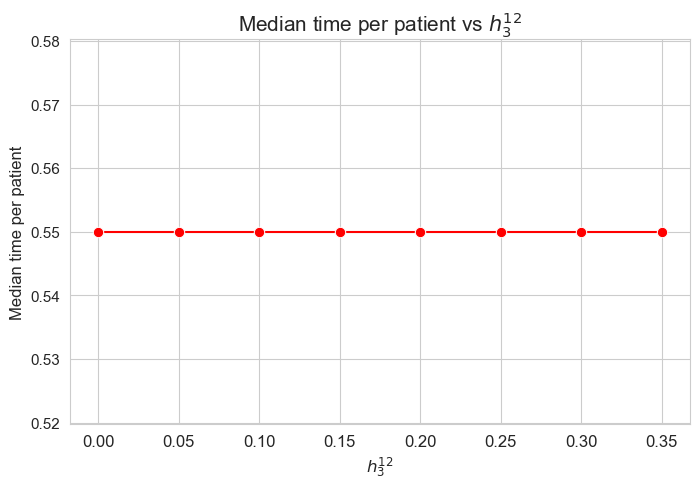

In [180]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_1_2']['median_time_per_patient'].values(), x=results2['h3_1_2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Median time per patient vs $h_3^{12}$', size=15)
ax.set_ylabel('Median time per patient', size=12)
ax.set_xlabel('$h_3^{12}$', size=12)
plt.xticks(results2['h3_1_2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$75$-quantile time spent per patient vs $h_3^{12}$**

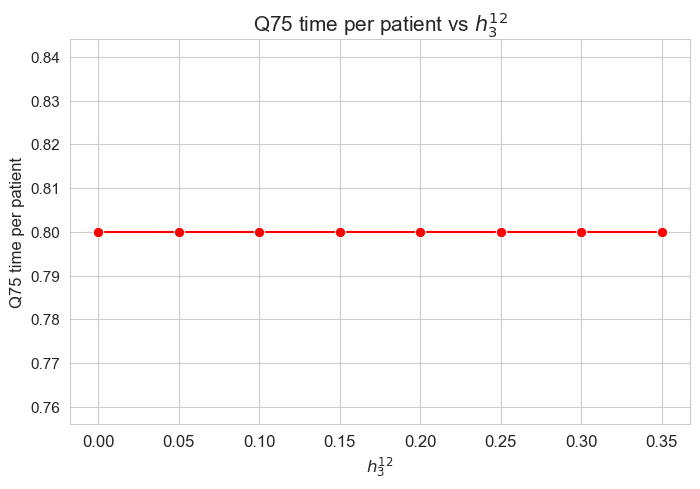

In [181]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_1_2']['Q75_time_per_patient'].values(), x=results2['h3_1_2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q75 time per patient vs $h_3^{12}$', size=15)
ax.set_ylabel('Q75 time per patient', size=12)
ax.set_xlabel('$h_3^{12}$', size=12)
plt.xticks(results2['h3_1_2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$25$-quantile time spent per patient vs $h_3^{12}$**

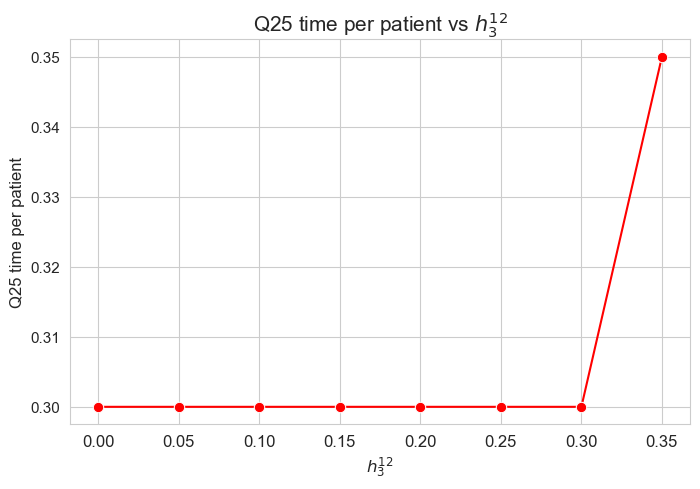

In [182]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_1_2']['Q25_time_per_patient'].values(), x=results2['h3_1_2']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q25 time per patient vs $h_3^{12}$', size=15)
ax.set_ylabel('Q25 time per patient', size=12)
ax.set_xlabel('$h_3^{12}$', size=12)
plt.xticks(results2['h3_1_2']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $w$ vs $h_3^{12}$**

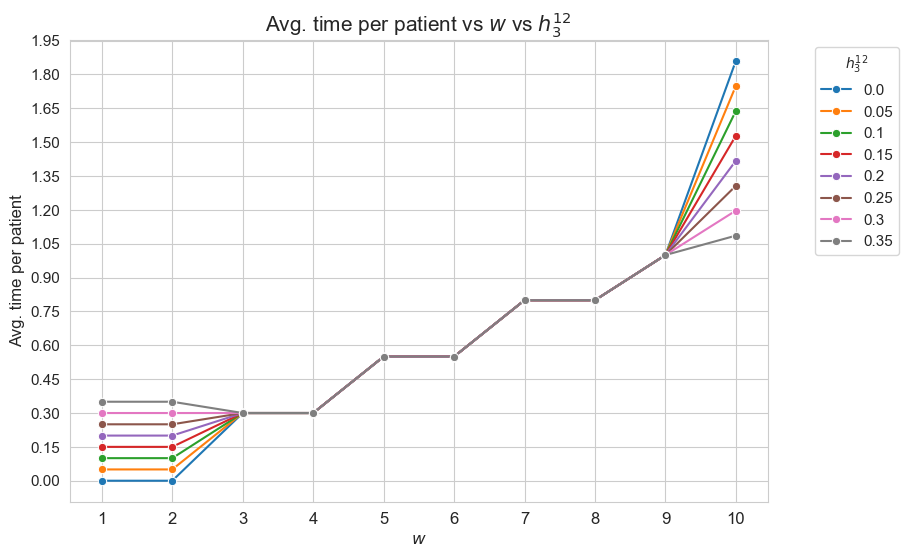

In [183]:
plt.figure(figsize=(9, 6))
for i, h3_1_2 in zip(results2['h3_1_2']['avg_time_patient_per_w'].keys(), results2['h3_1_2']['feasible']) :
    ax = sns.lineplot(y=results2['h3_1_2']['avg_time_patient_per_w'][i].values(), x=results2['h3_1_2']['avg_time_patient_per_w'][i].keys(), 
                      label=round(h3_1_2,2), marker='o', markersize=6)
plt.title('Avg. time per patient vs $w$ vs $h_3^{12}$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$w$', size=12)
plt.xticks(list(results2['h3_1_2']['avg_time_patient_per_w'][i].keys()), fontsize=12)
plt.yticks(np.arange(0,2, 0.15), fontsize=11)
plt.legend(title='$h_3^{12}$', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

**Analysis of $h_3^{34}$ parameter**

$h_3^{34} :=$  minimum time time spent in patients with $w_j \in \lbrace 3, 4 \rbrace$

In [184]:
params['n'] = 50 ; params['p']=500 ; params['h1']=6 ; params['h2']=1 ; params['h4']=4
params['h3_1_2'] = 0.10 
params['h3_3_4'] = None
params['h3_5_6'] = 0.55  
params['h3_7_8'] = 0.80 
params['h3_9_10'] = 1 

np.random.seed(123)
params['w'] = np.random.randint(1, 11, params['p']) 

parameter_list = np.arange(0, 0.8, 0.1)

In [185]:
results1 = get_results1('h3_3_4', parameter_list, params, model='integer')

In [186]:
results2 = get_results2('h3_3_4', parameter_list, results1)

- **Problem type (feasible - not feasible) vs $h_3^{34}$**

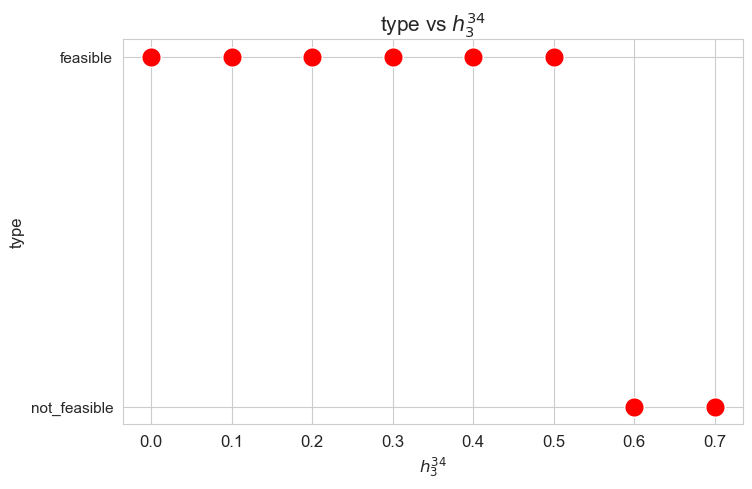

In [187]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(y=results2['h3_3_4']['type'], x=parameter_list, color='red', s=200)
plt.title('type vs $h_3^{34}$', size=15)
ax.set_ylabel('type', size=12)
ax.set_xlabel('$h_3^{34}$', size=12)
plt.xticks(parameter_list, fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Number of patients seen vs $h_3^{34}$**

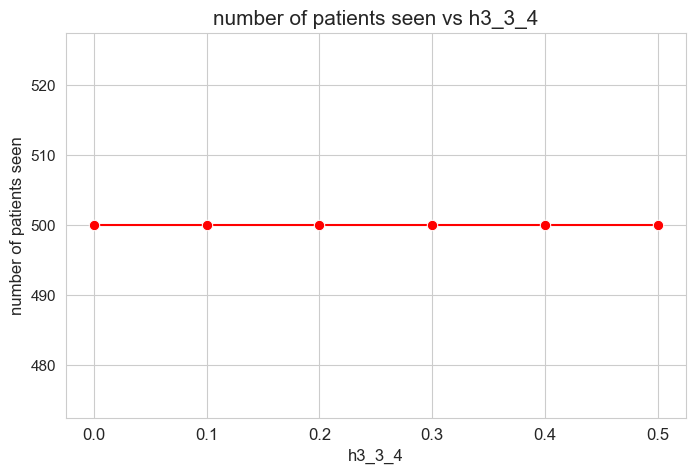

In [188]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_3_4']['num_patients_seen'].values(), x=results2['h3_3_4']['feasible'], 
                  marker='o', markersize=7.5, color='red')
plt.title('number of patients seen vs h3_3_4', size=15)
ax.set_ylabel('number of patients seen', size=12)
ax.set_xlabel('h3_3_4', size=12)
plt.xticks(results2['h3_3_4']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

 Even when $h_3^{34}=0$, the number of patients seen is the maximum possible $(p)$, thanks to the new constraint added in the binary model.

- **Optimal value of the objective function vs $h_3^{34}$**

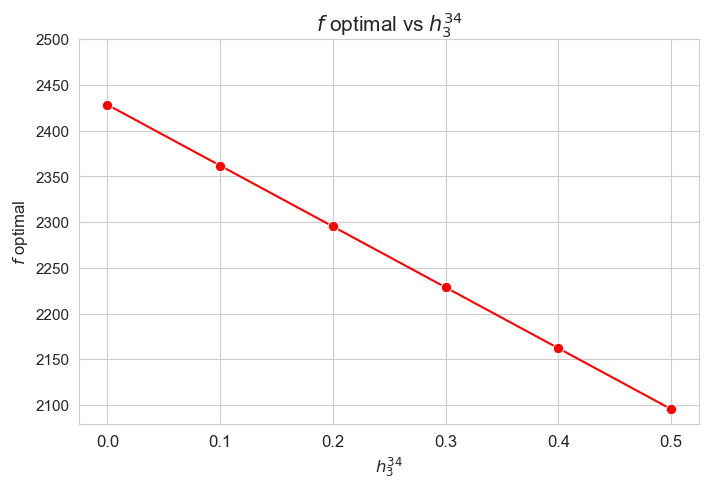

In [189]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_3_4']['f_optimal_feasible'].values(), x=results2['h3_3_4']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('$f$ optimal vs $h_3^{34}$', size=15)
ax.set_ylabel('$f$ optimal', size=12)
ax.set_xlabel('$h_3^{34}$', size=12)
plt.xticks(results2['h3_3_4']['feasible'], fontsize=12)
plt.yticks(np.arange(2100, 2550, 50), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $h_3^{34}$**

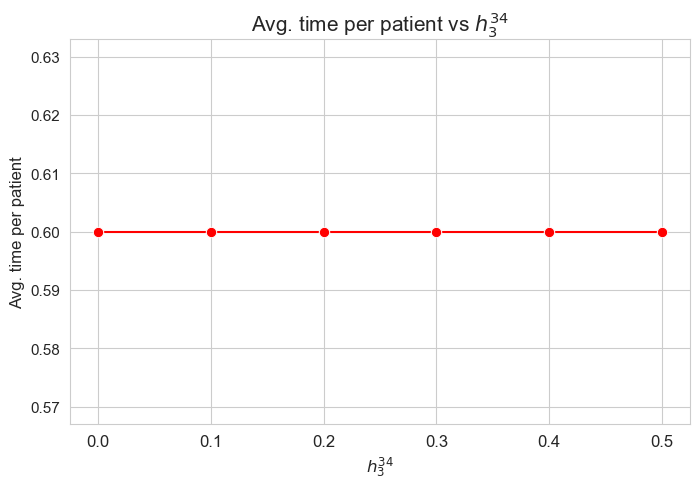

In [190]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_3_4']['avg_time_per_patient'].values(), x=results2['h3_3_4']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Avg. time per patient vs $h_3^{34}$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$h_3^{34}$', size=12)
plt.xticks(results2['h3_3_4']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Median time spent per patient vs $h_3^{34}$**

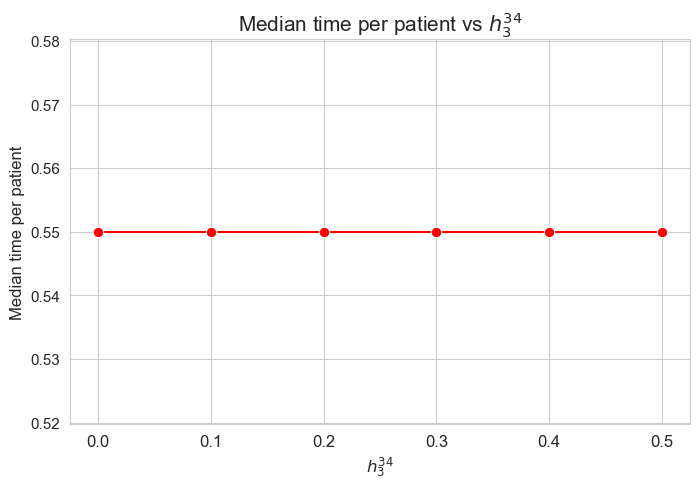

In [191]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_3_4']['median_time_per_patient'].values(), x=results2['h3_3_4']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Median time per patient vs $h_3^{34}$', size=15)
ax.set_ylabel('Median time per patient', size=12)
ax.set_xlabel('$h_3^{34}$', size=12)
plt.xticks(results2['h3_3_4']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$75$-quantile time spent per patient vs $h_3^{34}$**

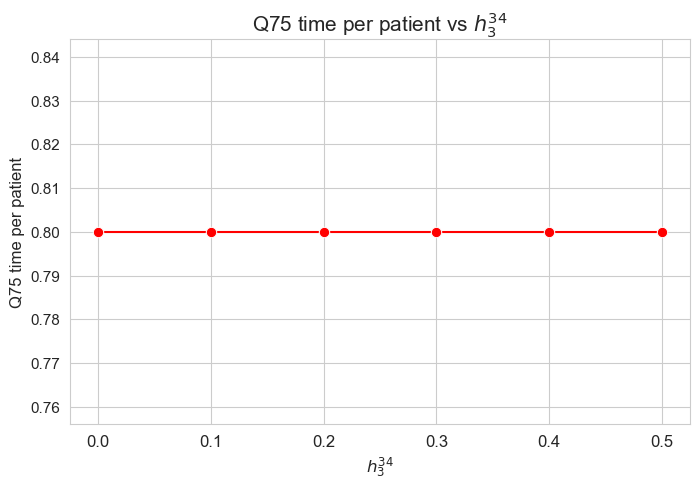

In [192]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_3_4']['Q75_time_per_patient'].values(), x=results2['h3_3_4']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q75 time per patient vs $h_3^{34}$', size=15)
ax.set_ylabel('Q75 time per patient', size=12)
ax.set_xlabel('$h_3^{34}$', size=12)
plt.xticks(results2['h3_3_4']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$25$-quantile time spent per patient vs $h_3^{34}$**

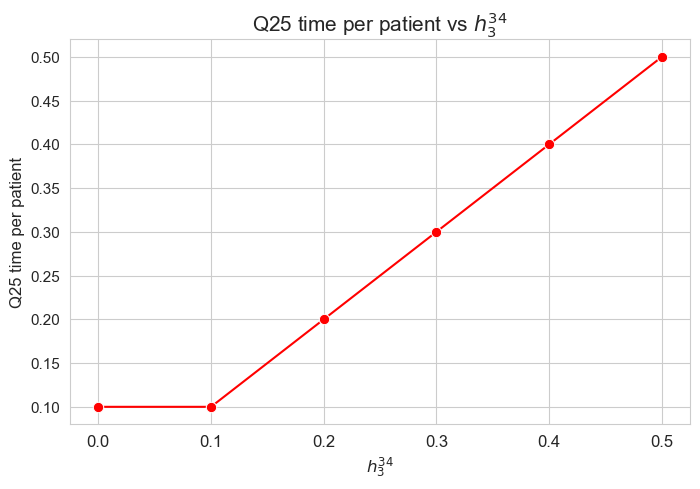

In [193]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_3_4']['Q25_time_per_patient'].values(), x=results2['h3_3_4']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q25 time per patient vs $h_3^{34}$', size=15)
ax.set_ylabel('Q25 time per patient', size=12)
ax.set_xlabel('$h_3^{34}$', size=12)
plt.xticks(results2['h3_3_4']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $w$ vs $h_3^{34}$**

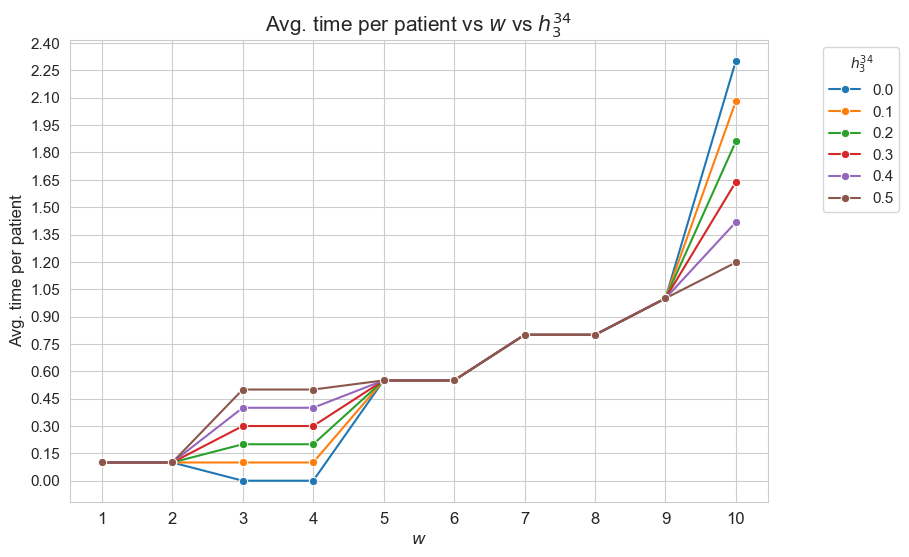

In [194]:
plt.figure(figsize=(9, 6))
for i, h3_3_4 in zip(results2['h3_3_4']['avg_time_patient_per_w'].keys(), results2['h3_3_4']['feasible']) :
    ax = sns.lineplot(y=results2['h3_3_4']['avg_time_patient_per_w'][i].values(), x=results2['h3_3_4']['avg_time_patient_per_w'][i].keys(), 
                      label=round(h3_3_4, 2), marker='o', markersize=6)
plt.title('Avg. time per patient vs $w$ vs $h_3^{34}$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$w$', size=12)
plt.xticks(list(results2['h3_3_4']['avg_time_patient_per_w'][i].keys()), fontsize=12)
plt.yticks(np.arange(0, 2.45, 0.15), fontsize=11)
plt.legend(title='$h_3^{34}$', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

**Analysis of $h_3^{56}$ parameter**

$h_3^{56} :=$  minimum time time spent in patients with $w_j \in \lbrace 5, 6 \rbrace$

In [195]:
params['n'] = 50 ; params['p']=500 ; params['h1']=6 ; params['h2']=1 ; params['h4']=4
params['h3_1_2'] = 0.10 
params['h3_3_4'] = 0.30
params['h3_5_6'] = None  
params['h3_7_8'] = 0.80 
params['h3_9_10'] = 1 

np.random.seed(123)
params['w'] = np.random.randint(1, 11, params['p']) 

parameter_list = np.arange(0, 1.1, 0.1)

In [196]:
results1 = get_results1('h3_5_6', parameter_list, params, model='integer')

In [197]:
results2 = get_results2('h3_5_6', parameter_list, results1)

- **Problem type (feasible - not feasible) vs $h_3^{56}$**

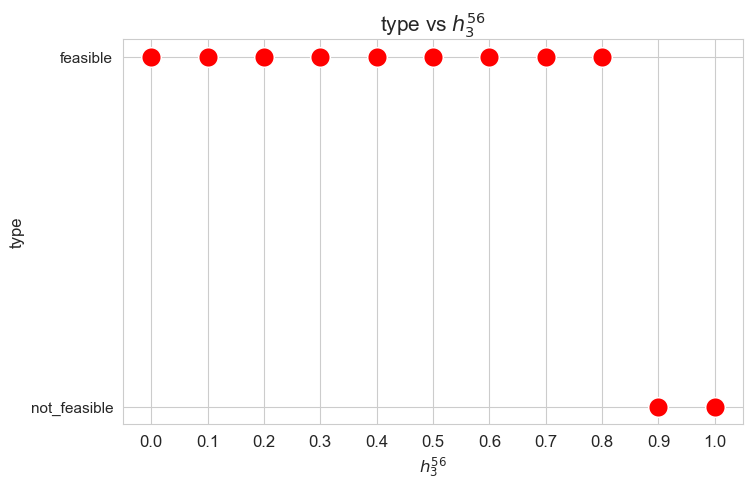

In [198]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(y=results2['h3_5_6']['type'], x=parameter_list, color='red', s=200)
plt.title('type vs $h_3^{56}$', size=15)
ax.set_ylabel('type', size=12)
ax.set_xlabel('$h_3^{56}$', size=12)
plt.xticks(parameter_list, fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Number of patients seen vs $h_3^{56}$**

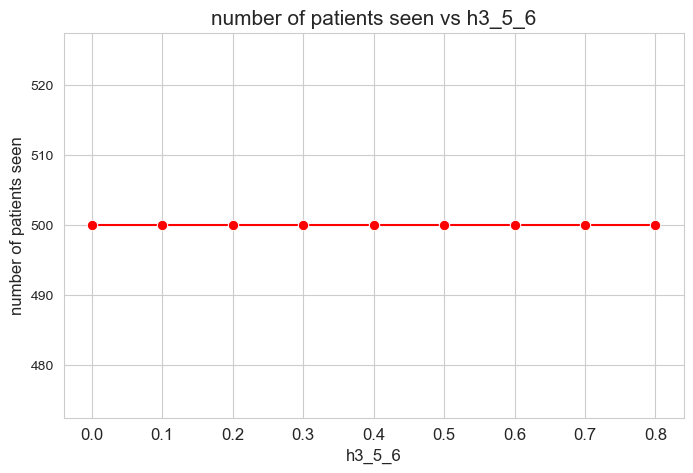

In [199]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_5_6']['num_patients_seen'].values(), x=results2['h3_5_6']['feasible'], 
                  marker='o', markersize=7.5, color='red')
plt.title('number of patients seen vs h3_5_6', size=15)
ax.set_ylabel('number of patients seen', size=12)
ax.set_xlabel('h3_5_6', size=12)
plt.xticks(results2['h3_5_6']['feasible'], fontsize=12)
# plt.yticks(np.arange(400, 520, 20), fontsize=11)
plt.show()

**Interpretation of the results:**

 Even when $h_3^{56}=0$, the number of patients seen is the maximum possible $(p)$, thanks to the new constraint added in the binary model.

- **Optimal value of the objective function vs $h_3^{56}$**

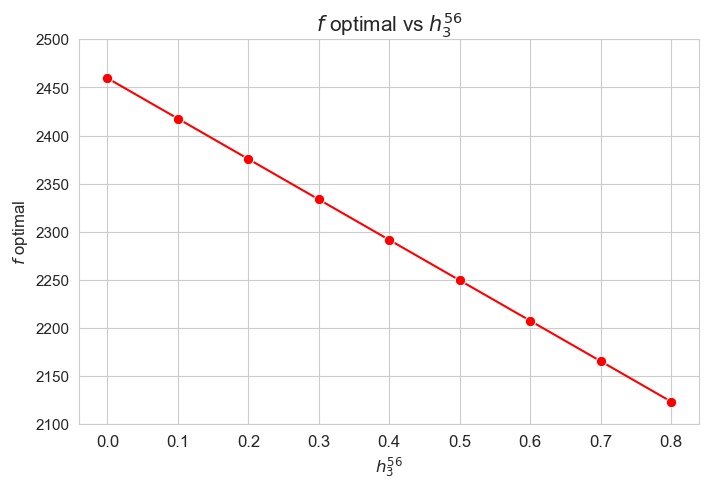

In [200]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_5_6']['f_optimal_feasible'].values(), x=results2['h3_5_6']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('$f$ optimal vs $h_3^{56}$', size=15)
ax.set_ylabel('$f$ optimal', size=12)
ax.set_xlabel('$h_3^{56}$', size=12)
plt.xticks(results2['h3_5_6']['feasible'], fontsize=12)
plt.yticks(np.arange(2100, 2550, 50), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $h_3^{56}$**

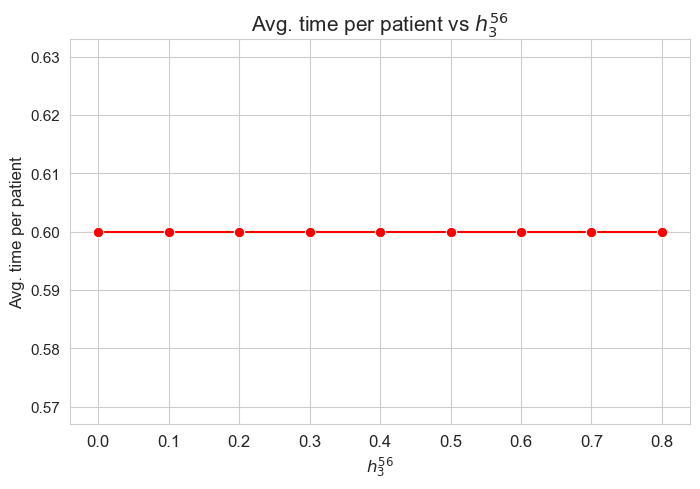

In [201]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_5_6']['avg_time_per_patient'].values(), x=results2['h3_5_6']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Avg. time per patient vs $h_3^{56}$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$h_3^{56}$', size=12)
plt.xticks(results2['h3_5_6']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Median time spent per patient vs $h_3^{56}$**

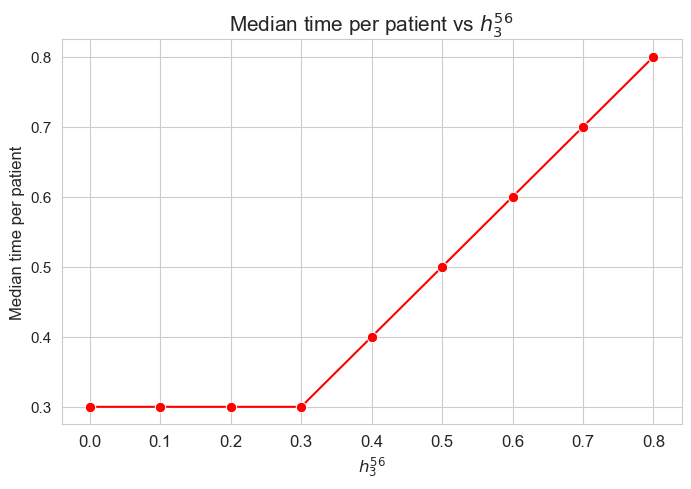

In [202]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_5_6']['median_time_per_patient'].values(), x=results2['h3_5_6']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Median time per patient vs $h_3^{56}$', size=15)
ax.set_ylabel('Median time per patient', size=12)
ax.set_xlabel('$h_3^{56}$', size=12)
plt.xticks(results2['h3_5_6']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$75$-quantile time spent per patient vs $h_3^{56}$**

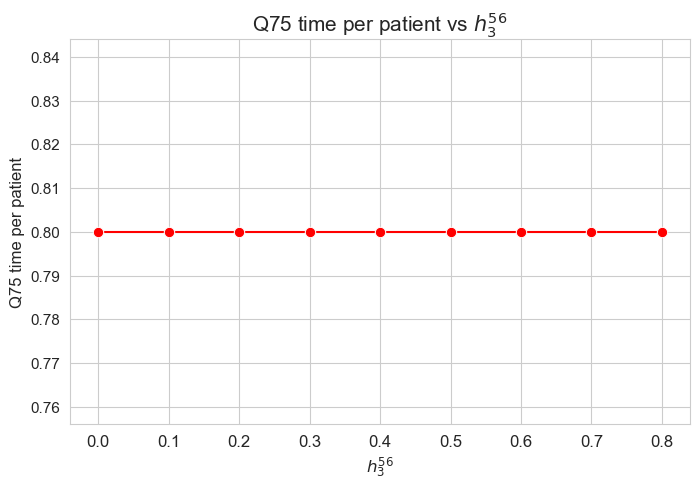

In [203]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_5_6']['Q75_time_per_patient'].values(), x=results2['h3_5_6']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q75 time per patient vs $h_3^{56}$', size=15)
ax.set_ylabel('Q75 time per patient', size=12)
ax.set_xlabel('$h_3^{56}$', size=12)
plt.xticks(results2['h3_5_6']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$25$-quantile time spent per patient vs $h_3^{34}$**

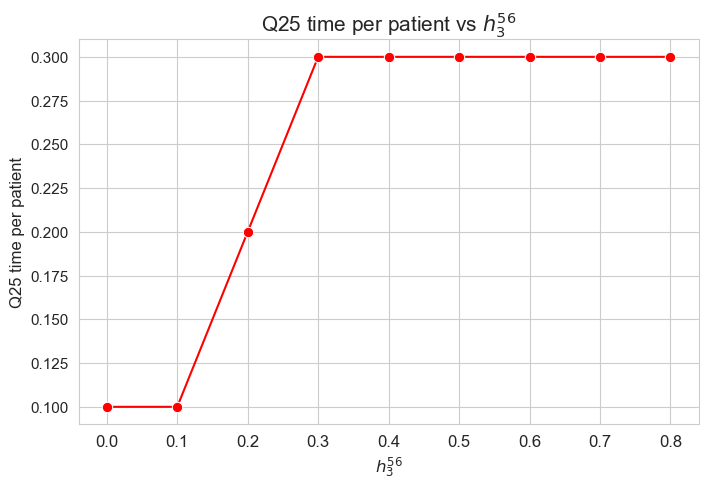

In [204]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_5_6']['Q25_time_per_patient'].values(), x=results2['h3_5_6']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q25 time per patient vs $h_3^{56}$', size=15)
ax.set_ylabel('Q25 time per patient', size=12)
ax.set_xlabel('$h_3^{56}$', size=12)
plt.xticks(results2['h3_5_6']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $w$ vs $h_3^{56}$**

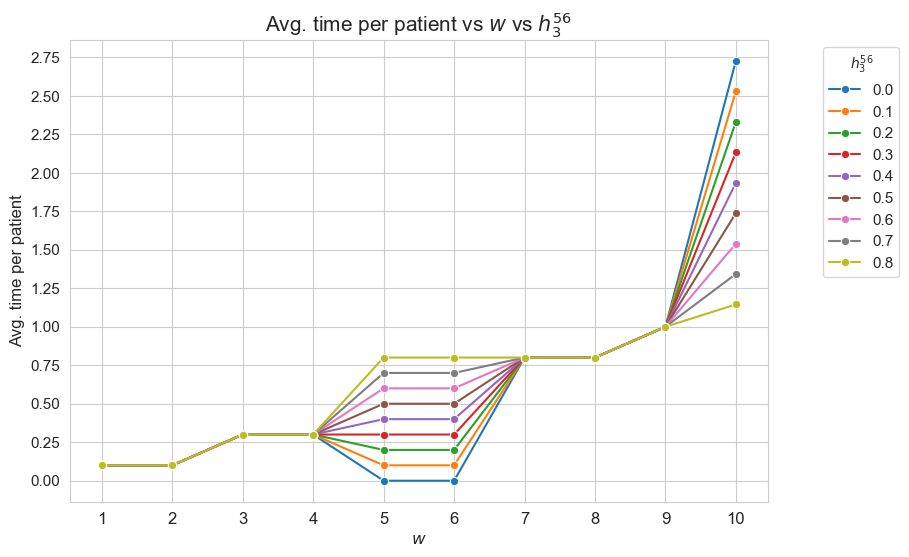

In [205]:
plt.figure(figsize=(9, 6))
for i, h3_5_6 in zip(results2['h3_5_6']['avg_time_patient_per_w'].keys(), results2['h3_5_6']['feasible']) :
    ax = sns.lineplot(y=results2['h3_5_6']['avg_time_patient_per_w'][i].values(), x=results2['h3_5_6']['avg_time_patient_per_w'][i].keys(), 
                      label=round(h3_5_6, 2), marker='o', markersize=6)
plt.title('Avg. time per patient vs $w$ vs $h_3^{56}$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$w$', size=12)
plt.xticks(list(results2['h3_5_6']['avg_time_patient_per_w'][i].keys()), fontsize=12)
plt.yticks(np.arange(0,3, 0.25), fontsize=11)
plt.legend(title='$h_3^{56}$', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

**Analysis of $h_3^{78}$ parameter**

$h_3^{78} :=$  minimum time time spent in patients with $w_j \in \lbrace 7, 8 \rbrace$

In [206]:
params['n'] = 50 ; params['p']=500 ; params['h1']=6 ; params['h2']=1 ; params['h4']=4
params['h3_1_2'] = 0.10 
params['h3_3_4'] = 0.30
params['h3_5_6'] = 0.55  
params['h3_7_8'] = None 
params['h3_9_10'] = 1 

np.random.seed(123)
params['w'] = np.random.randint(1, 11, params['p']) 

parameter_list = np.arange(0, 1.3, 0.1)

In [207]:
results1 = get_results1('h3_7_8', parameter_list, params, model='integer')

In [208]:
results2 = get_results2('h3_7_8', parameter_list, results1)

- **Problem type (feasible - not feasible) vs $h_3^{78}$**

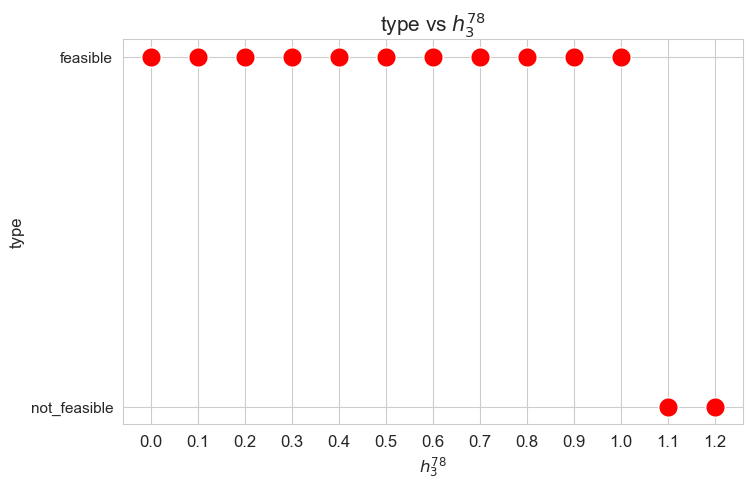

In [209]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(y=results2['h3_7_8']['type'], x=parameter_list, color='red', s=200)
plt.title('type vs $h_3^{78}$', size=15)
ax.set_ylabel('type', size=12)
ax.set_xlabel('$h_3^{78}$', size=12)
plt.xticks(parameter_list, fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Number of patients seen vs $h_3^{78}$**

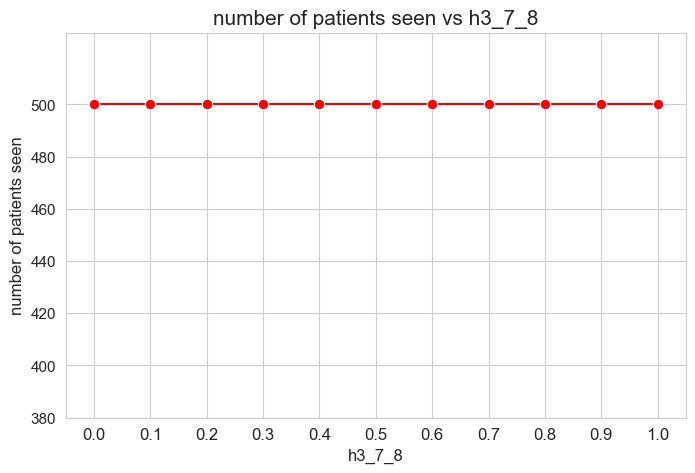

In [210]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_7_8']['num_patients_seen'].values(), x=results2['h3_7_8']['feasible'], 
                  marker='o', markersize=7.5, color='red')
plt.title('number of patients seen vs h3_7_8', size=15)
ax.set_ylabel('number of patients seen', size=12)
ax.set_xlabel('h3_7_8', size=12)
plt.xticks(results2['h3_7_8']['feasible'], fontsize=12)
plt.yticks(np.arange(380, 520, 20), fontsize=11)
plt.show()

**Interpretation of the results:**

 Even when $h_3^{78}=0$, the number of patients seen is the maximum possible $(p)$, thanks to the new constraint added in the binary model.

- **Optimal value of the objective function vs $h_3^{78}$**

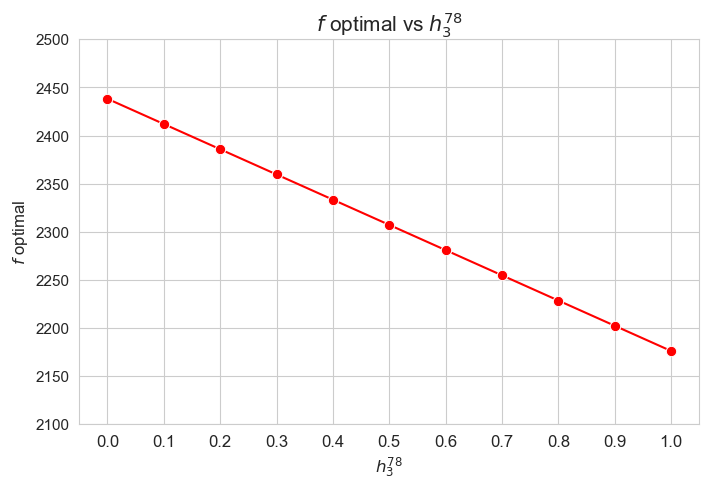

In [211]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_7_8']['f_optimal_feasible'].values(), x=results2['h3_7_8']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('$f$ optimal vs $h_3^{78}$', size=15)
ax.set_ylabel('$f$ optimal', size=12)
ax.set_xlabel('$h_3^{78}$', size=12)
plt.xticks(results2['h3_7_8']['feasible'], fontsize=12)
plt.yticks(np.arange(2100, 2550, 50), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $h_3^{78}$**

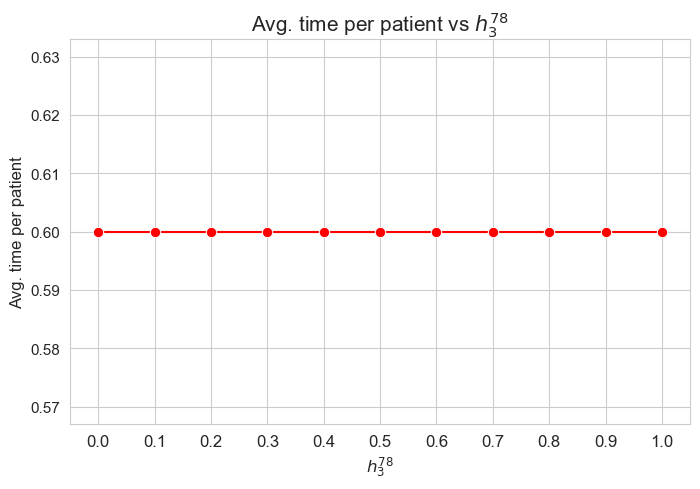

In [212]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_7_8']['avg_time_per_patient'].values(), x=results2['h3_7_8']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Avg. time per patient vs $h_3^{78}$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$h_3^{78}$', size=12)
plt.xticks(results2['h3_7_8']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Median time spent per patient vs $h_3^{78}$**

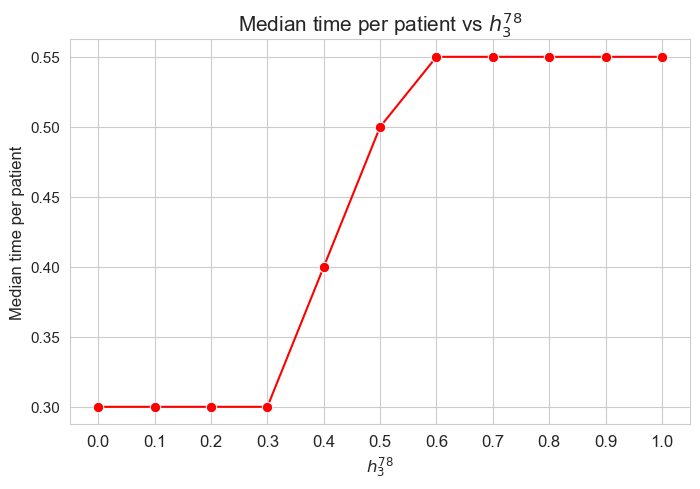

In [213]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_7_8']['median_time_per_patient'].values(), x=results2['h3_7_8']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Median time per patient vs $h_3^{78}$', size=15)
ax.set_ylabel('Median time per patient', size=12)
ax.set_xlabel('$h_3^{78}$', size=12)
plt.xticks(results2['h3_7_8']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$75$-quantile time spent per patient vs $h_3^{78}$**

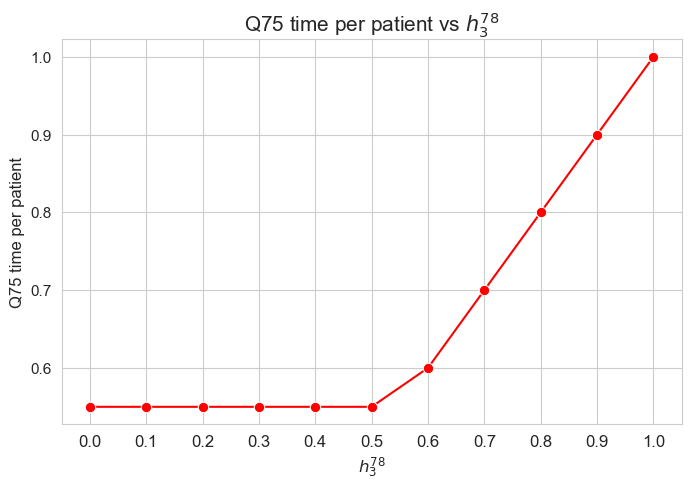

In [214]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_7_8']['Q75_time_per_patient'].values(), x=results2['h3_7_8']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q75 time per patient vs $h_3^{78}$', size=15)
ax.set_ylabel('Q75 time per patient', size=12)
ax.set_xlabel('$h_3^{78}$', size=12)
plt.xticks(results2['h3_7_8']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$25$-quantile time spent per patient vs $h_3^{78}$**

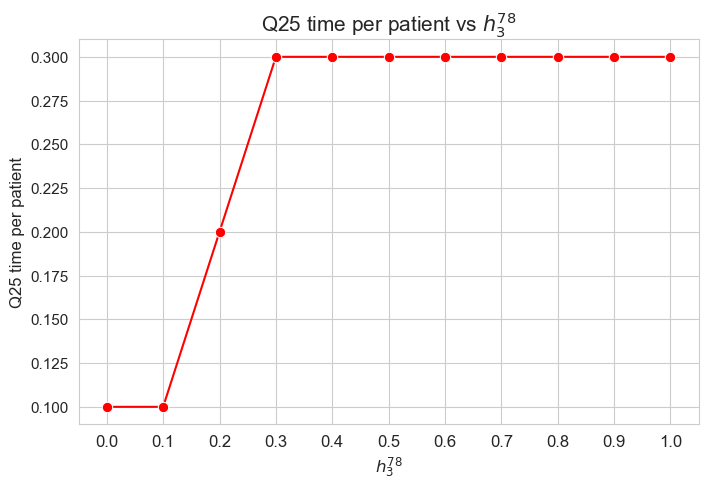

In [215]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_7_8']['Q25_time_per_patient'].values(), x=results2['h3_7_8']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q25 time per patient vs $h_3^{78}$', size=15)
ax.set_ylabel('Q25 time per patient', size=12)
ax.set_xlabel('$h_3^{78}$', size=12)
plt.xticks(results2['h3_7_8']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $w$ vs $h_3^{78}$**

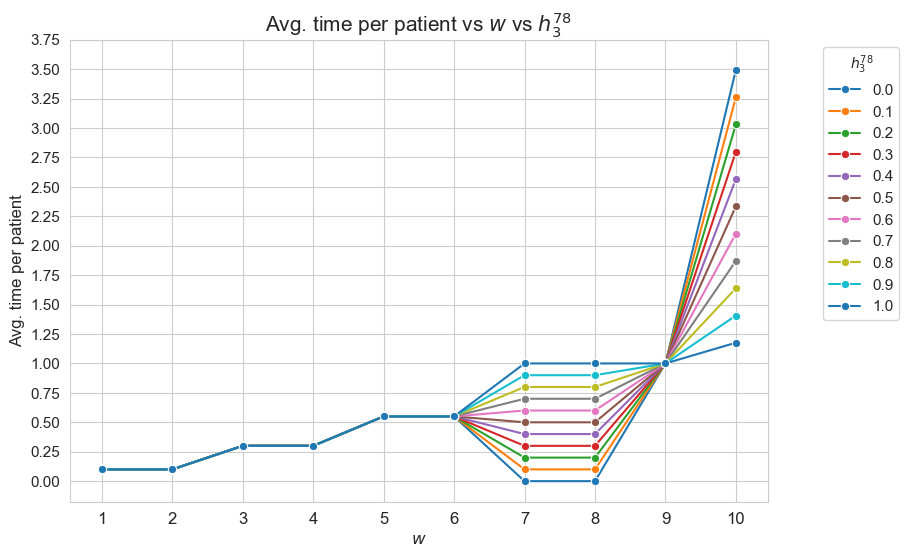

In [216]:
plt.figure(figsize=(9, 6))
for i, h3_7_8 in zip(results2['h3_7_8']['avg_time_patient_per_w'].keys(), results2['h3_7_8']['feasible']) :
    ax = sns.lineplot(y=results2['h3_7_8']['avg_time_patient_per_w'][i].values(), x=results2['h3_7_8']['avg_time_patient_per_w'][i].keys(), 
                      label=round(h3_7_8, 2), marker='o', markersize=6)
plt.title('Avg. time per patient vs $w$ vs $h_3^{78}$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$w$', size=12)
plt.xticks(list(results2['h3_7_8']['avg_time_patient_per_w'][i].keys()), fontsize=12)
plt.yticks(np.arange(0,4, 0.25), fontsize=11)
plt.legend(title='$h_3^{78}$', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

**Analysis of $h_3^{910}$ parameter**

$h_3^{910} :=$  minimum time time spent in patients with $w_j \in \lbrace 9, 10 \rbrace$

In [217]:
params['n'] = 50 ; params['p']=500 ; params['h1']=6 ; params['h2']=1 ; params['h4']=4
params['h3_1_2'] = 0.10 
params['h3_3_4'] = 0.30
params['h3_5_6'] = 0.55  
params['h3_7_8'] = 0.80 
params['h3_9_10'] = None 

np.random.seed(123)
params['w'] = np.random.randint(1, 11, params['p']) 

parameter_list = np.arange(0, 1.6, 0.1)

In [218]:
results1 = get_results1('h3_9_10', parameter_list, params, model='integer')

In [219]:
results2 = get_results2('h3_9_10', parameter_list, results1)

- **Problem type (feasible - not feasible) vs $h_3^{910}$**

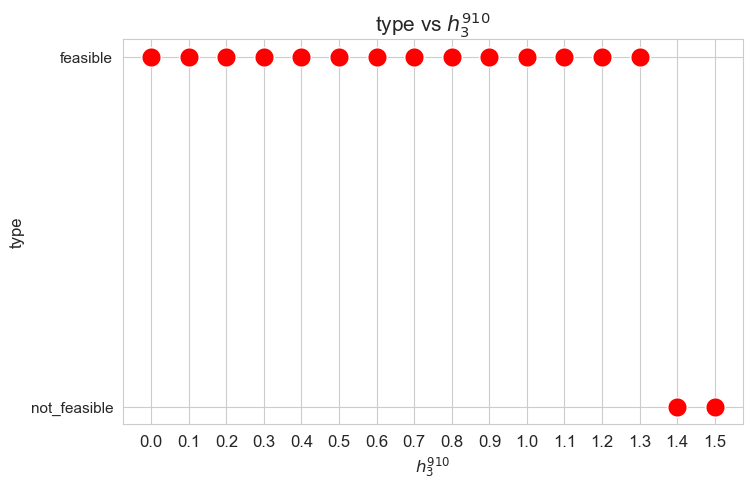

In [220]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(y=results2['h3_9_10']['type'], x=parameter_list, color='red', s=200)
plt.title('type vs $h_3^{910}$', size=15)
ax.set_ylabel('type', size=12)
ax.set_xlabel('$h_3^{910}$', size=12)
plt.xticks(parameter_list, fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Number of patients seen vs $h_3^{910}$**

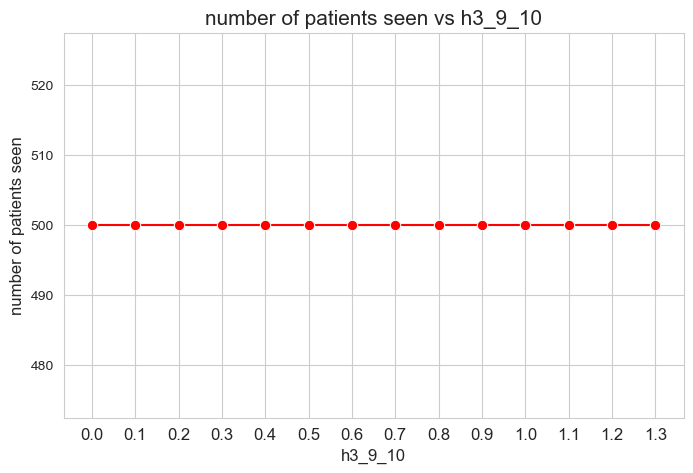

In [221]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_9_10']['num_patients_seen'].values(), x=results2['h3_9_10']['feasible'], 
                  marker='o', markersize=7.5, color='red')
plt.title('number of patients seen vs h3_9_10', size=15)
ax.set_ylabel('number of patients seen', size=12)
ax.set_xlabel('h3_9_10', size=12)
plt.xticks(results2['h3_9_10']['feasible'], fontsize=12)
# plt.yticks(np.arange(420, 520, 20), fontsize=11)
plt.show()

**Interpretation of the results:**

 Even when $h_3^{910}=0$, the number of patients seen is the maximum possible $(p)$, thanks to the new constraint added in the binary model.

- **Optimal value of the objective function vs $h_3^{910}$**

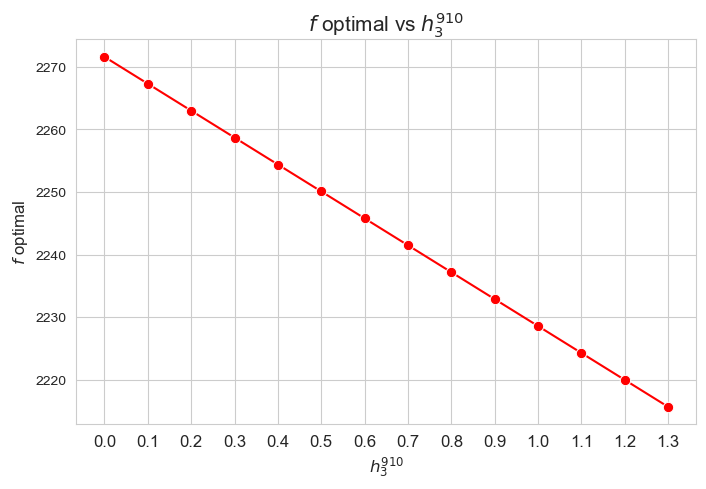

In [222]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_9_10']['f_optimal_feasible'].values(), x=results2['h3_9_10']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('$f$ optimal vs $h_3^{910}$', size=15)
ax.set_ylabel('$f$ optimal', size=12)
ax.set_xlabel('$h_3^{910}$', size=12)
plt.xticks(results2['h3_9_10']['feasible'], fontsize=12)
# plt.yticks(np.arange(2100, 2550, 50), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $h_3^{910}$**

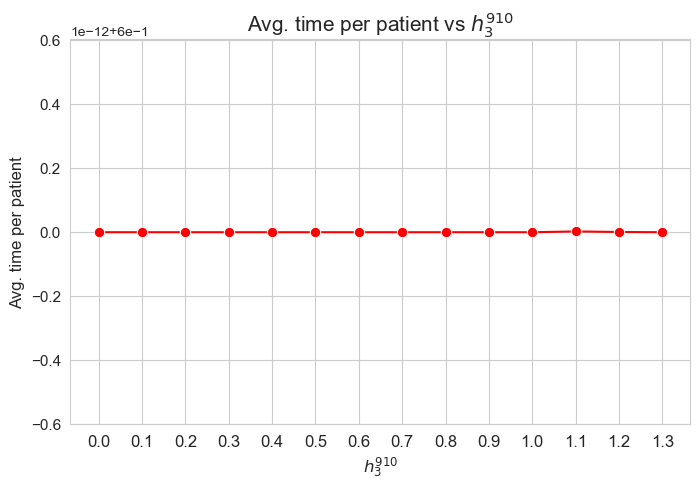

In [223]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_9_10']['avg_time_per_patient'].values(), x=results2['h3_9_10']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Avg. time per patient vs $h_3^{910}$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$h_3^{910}$', size=12)
plt.xticks(results2['h3_9_10']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Median time spent per patient vs $h_3^{910}$**

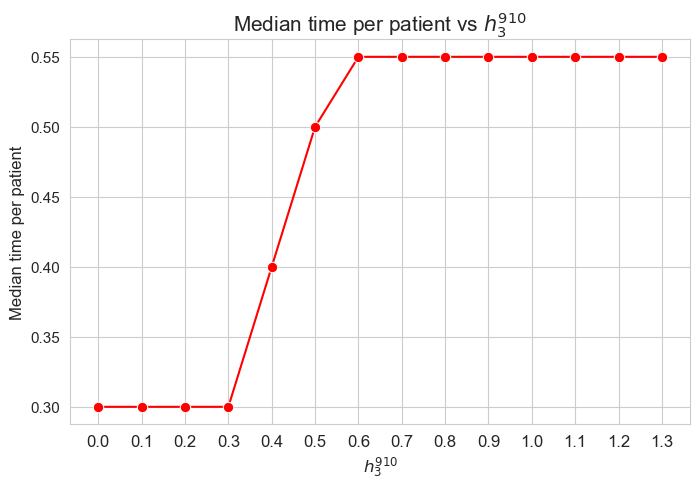

In [224]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_9_10']['median_time_per_patient'].values(), x=results2['h3_9_10']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Median time per patient vs $h_3^{910}$', size=15)
ax.set_ylabel('Median time per patient', size=12)
ax.set_xlabel('$h_3^{910}$', size=12)
plt.xticks(results2['h3_9_10']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$75$-quantile time spent per patient vs $h_3^{910}$**

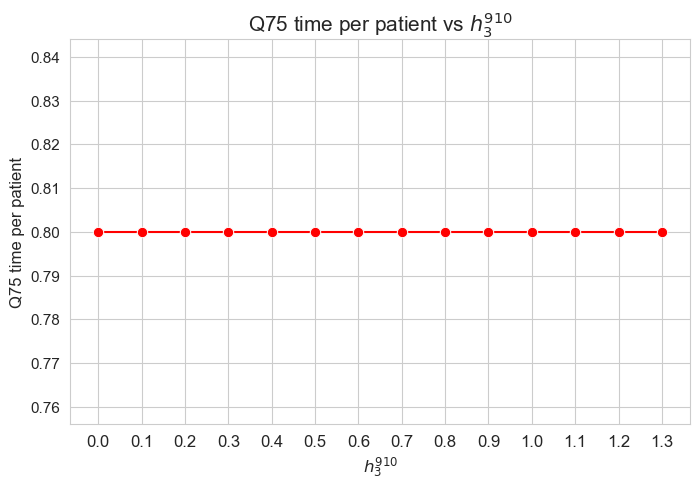

In [225]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_9_10']['Q75_time_per_patient'].values(), x=results2['h3_9_10']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q75 time per patient vs $h_3^{910}$', size=15)
ax.set_ylabel('Q75 time per patient', size=12)
ax.set_xlabel('$h_3^{910}$', size=12)
plt.xticks(results2['h3_9_10']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **$25$-quantile time spent per patient vs $h_3^{910}$**

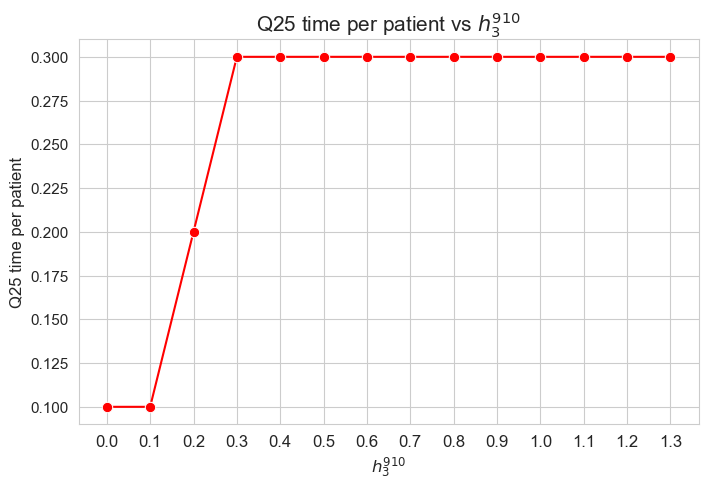

In [226]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(y=results2['h3_9_10']['Q25_time_per_patient'].values(), x=results2['h3_9_10']['feasible'], marker='o', markersize=7.5, color='red')
plt.title('Q25 time per patient vs $h_3^{910}$', size=15)
ax.set_ylabel('Q25 time per patient', size=12)
ax.set_xlabel('$h_3^{910}$', size=12)
plt.xticks(results2['h3_9_10']['feasible'], fontsize=12)
plt.yticks(fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

- **Average time spent per patient vs $w$ vs $h_3^{910}$**

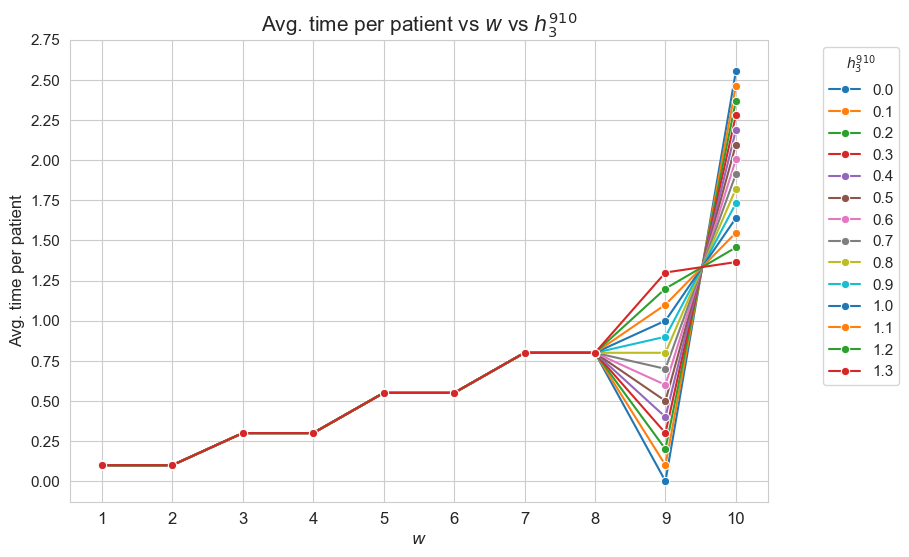

In [227]:
plt.figure(figsize=(9, 6))
for i, h3_9_10 in zip(results2['h3_9_10']['avg_time_patient_per_w'].keys(), results2['h3_9_10']['feasible']) :
    ax = sns.lineplot(y=results2['h3_9_10']['avg_time_patient_per_w'][i].values(), x=results2['h3_9_10']['avg_time_patient_per_w'][i].keys(), 
                      label=round(h3_9_10, 2), marker='o', markersize=6)
plt.title('Avg. time per patient vs $w$ vs $h_3^{910}$', size=15)
ax.set_ylabel('Avg. time per patient', size=12)
ax.set_xlabel('$w$', size=12)
plt.xticks(list(results2['h3_9_10']['avg_time_patient_per_w'][i].keys()), fontsize=12)
plt.yticks(np.arange(0,3, 0.25), fontsize=11)
plt.legend(title='$h_3^{910}$', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=11)
plt.show()

**Interpretation of the results:**

Analogous interpretation to the one made for the linear model.

### **Analysis of multiple parameters** 

In this section we make a sensitivity analysis of some of the parameters of the problem, following an multiple  approach, in the sense that we analyzed several parameters at once.

This analysis is essentially carried out using the function `get_results1_multi_IM` and `get_results2_multi_IM`.

In [228]:
params = dict()

def time_seeing_patient(j, t_optimal, params):
    return np.sum([t_optimal[i, j] for i in range(0,params['n'])])

##### **Analysis of $(h_3^{12}, h_3^{34}, h_3^{56}, h_3^{78}, h_3^{910})$ combination of parameters**

- $h_3 :=$  minimum time time spent in each patient, taking into account their severity/importance (this quantity depends on $w_j$).


In [229]:
# Defining the values of the rest of parameters and setting h3_1_2, h3_3_4, h3_5_6, h3_7_8, h3_9_10 as None.

params['n'] = 50 ; params['p']=500 ; params['h1']=6 ; params['h2']=1 ; params['h4']=4
params['h3_1_2'] = None 
params['h3_3_4'] = None
params['h3_5_6'] = None  
params['h3_7_8'] = None 
params['h3_9_10'] = None 

np.random.seed(123)
params['w'] = np.random.randint(1, 11, params['p']) 

# Defining the parameter combination values as a list.
param_combi_list = product([0, 0.1, 0.4], [0, 0.2, 0.5], [0, 0.4, 0.8], [0, 0.6, 1], [0, 0.7, 1.2])
param_combi_list = list(param_combi_list)

# Defining the parameter names as a tuple.
param_names = ('h3_1_2', 'h3_3_4', 'h3_5_6', 'h3_7_8', 'h3_9_10')

As before, we have run the code once and then saved the results in pickle files, in order to save time.

In [230]:
#results1_multi = get_results1_multi(('h3_1_2', 'h3_3_4', 'h3_5_6', 'h3_7_8', 'h3_9_10'), param_combi_list, params, model='integer')
#results2_multi = get_results2_multi(('h3_1_2', 'h3_3_4', 'h3_5_6', 'h3_7_8', 'h3_9_10'), param_combi_list, results1_multi)

In [231]:
# save a dictionary as a pickle
#with open('results1_multi_IM.pickle', 'wb') as file:
    # Use pickle's dump function to write the dict to the opened file.
    #pickle.dump(results1_multi, file)

#with open('results2_multi_IM.pickle', 'wb') as file:
    # Use pickle's dump function to write the dict to the opened file.
    #pickle.dump(results2_multi, file)

In [232]:
# Open a dictionary saved as a pickle
with open(r"C:\Users\fscielzo\Documents\Large-Data\Optimization\results1_multi_IM.pickle", 'rb') as file:
    # Read back the pickled file
    results1_multi = pickle.load(file)

# Open a dictionary saved as a pickle
with open(r"C:\Users\fscielzo\Documents\Large-Data\Optimization\results2_multi_IM.pickle", 'rb') as file:
    # Read back the pickled file
    results2_multi = pickle.load(file)

- **Problem type (feasible - not feasible) vs $(h_3^{12}, h_3^{34}, h_3^{56}, h_3^{78}, h_3^{910})$**

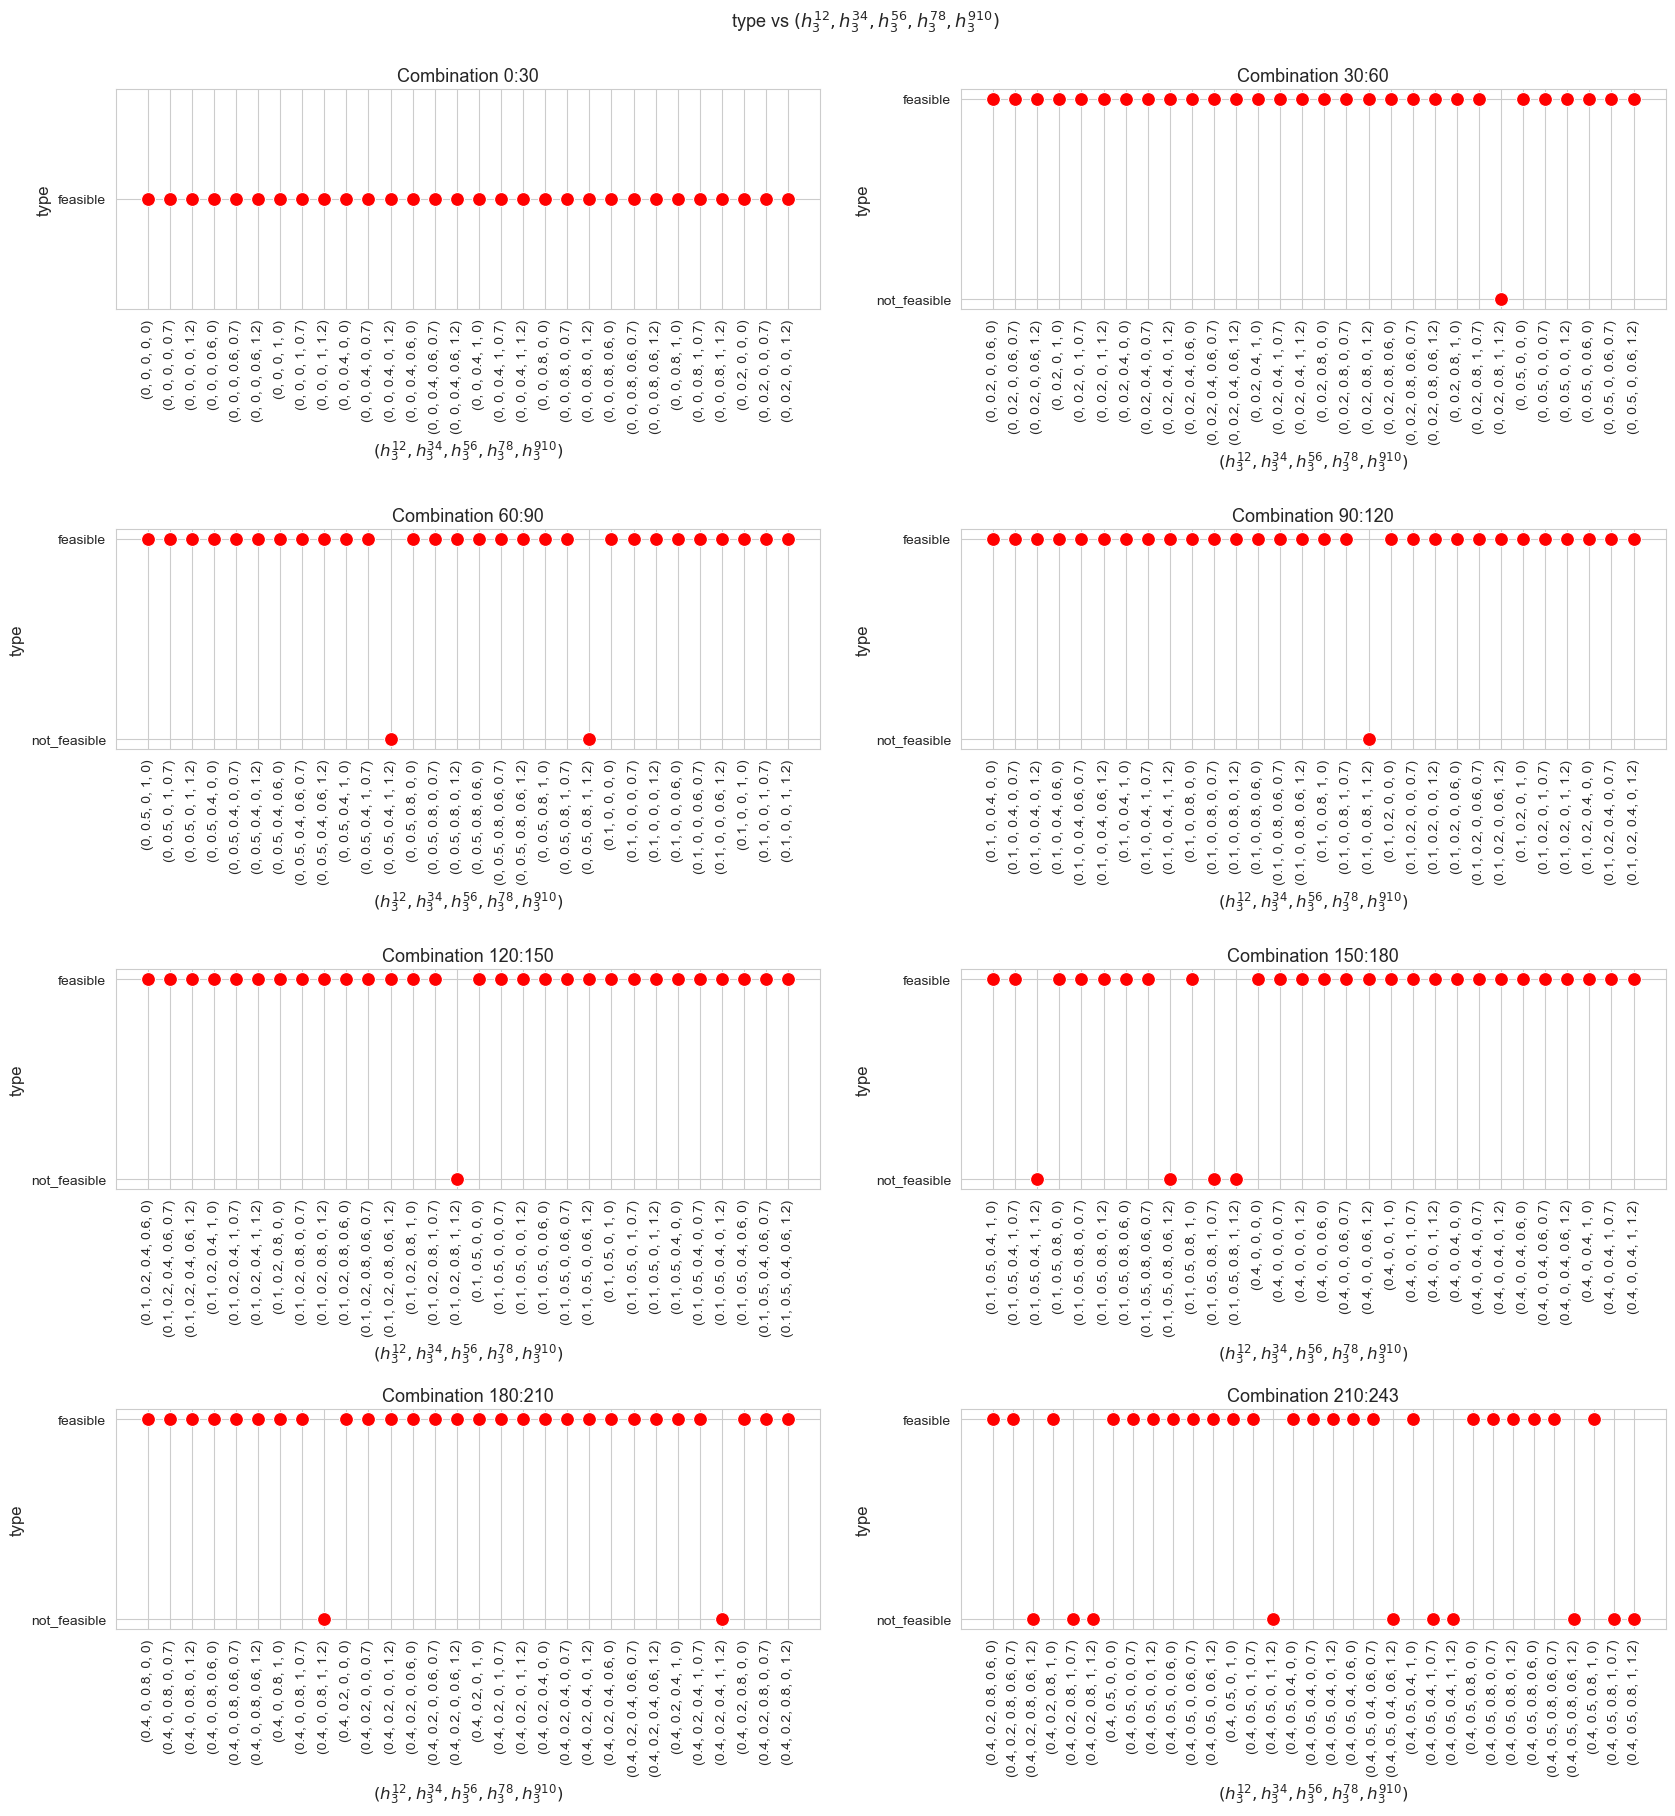

In [233]:
type_multi_plot(results2_multi=results2_multi, n_cols=2, figsize=(20, 20), interval_width=30)

**Interpretation of the results:**

Same interpretation to the one made for the linear model, because the results are the same.

- **Number of patients seen vs $(h_3^{12}, h_3^{34}, h_3^{56}, h_3^{78}, h_3^{910})$**

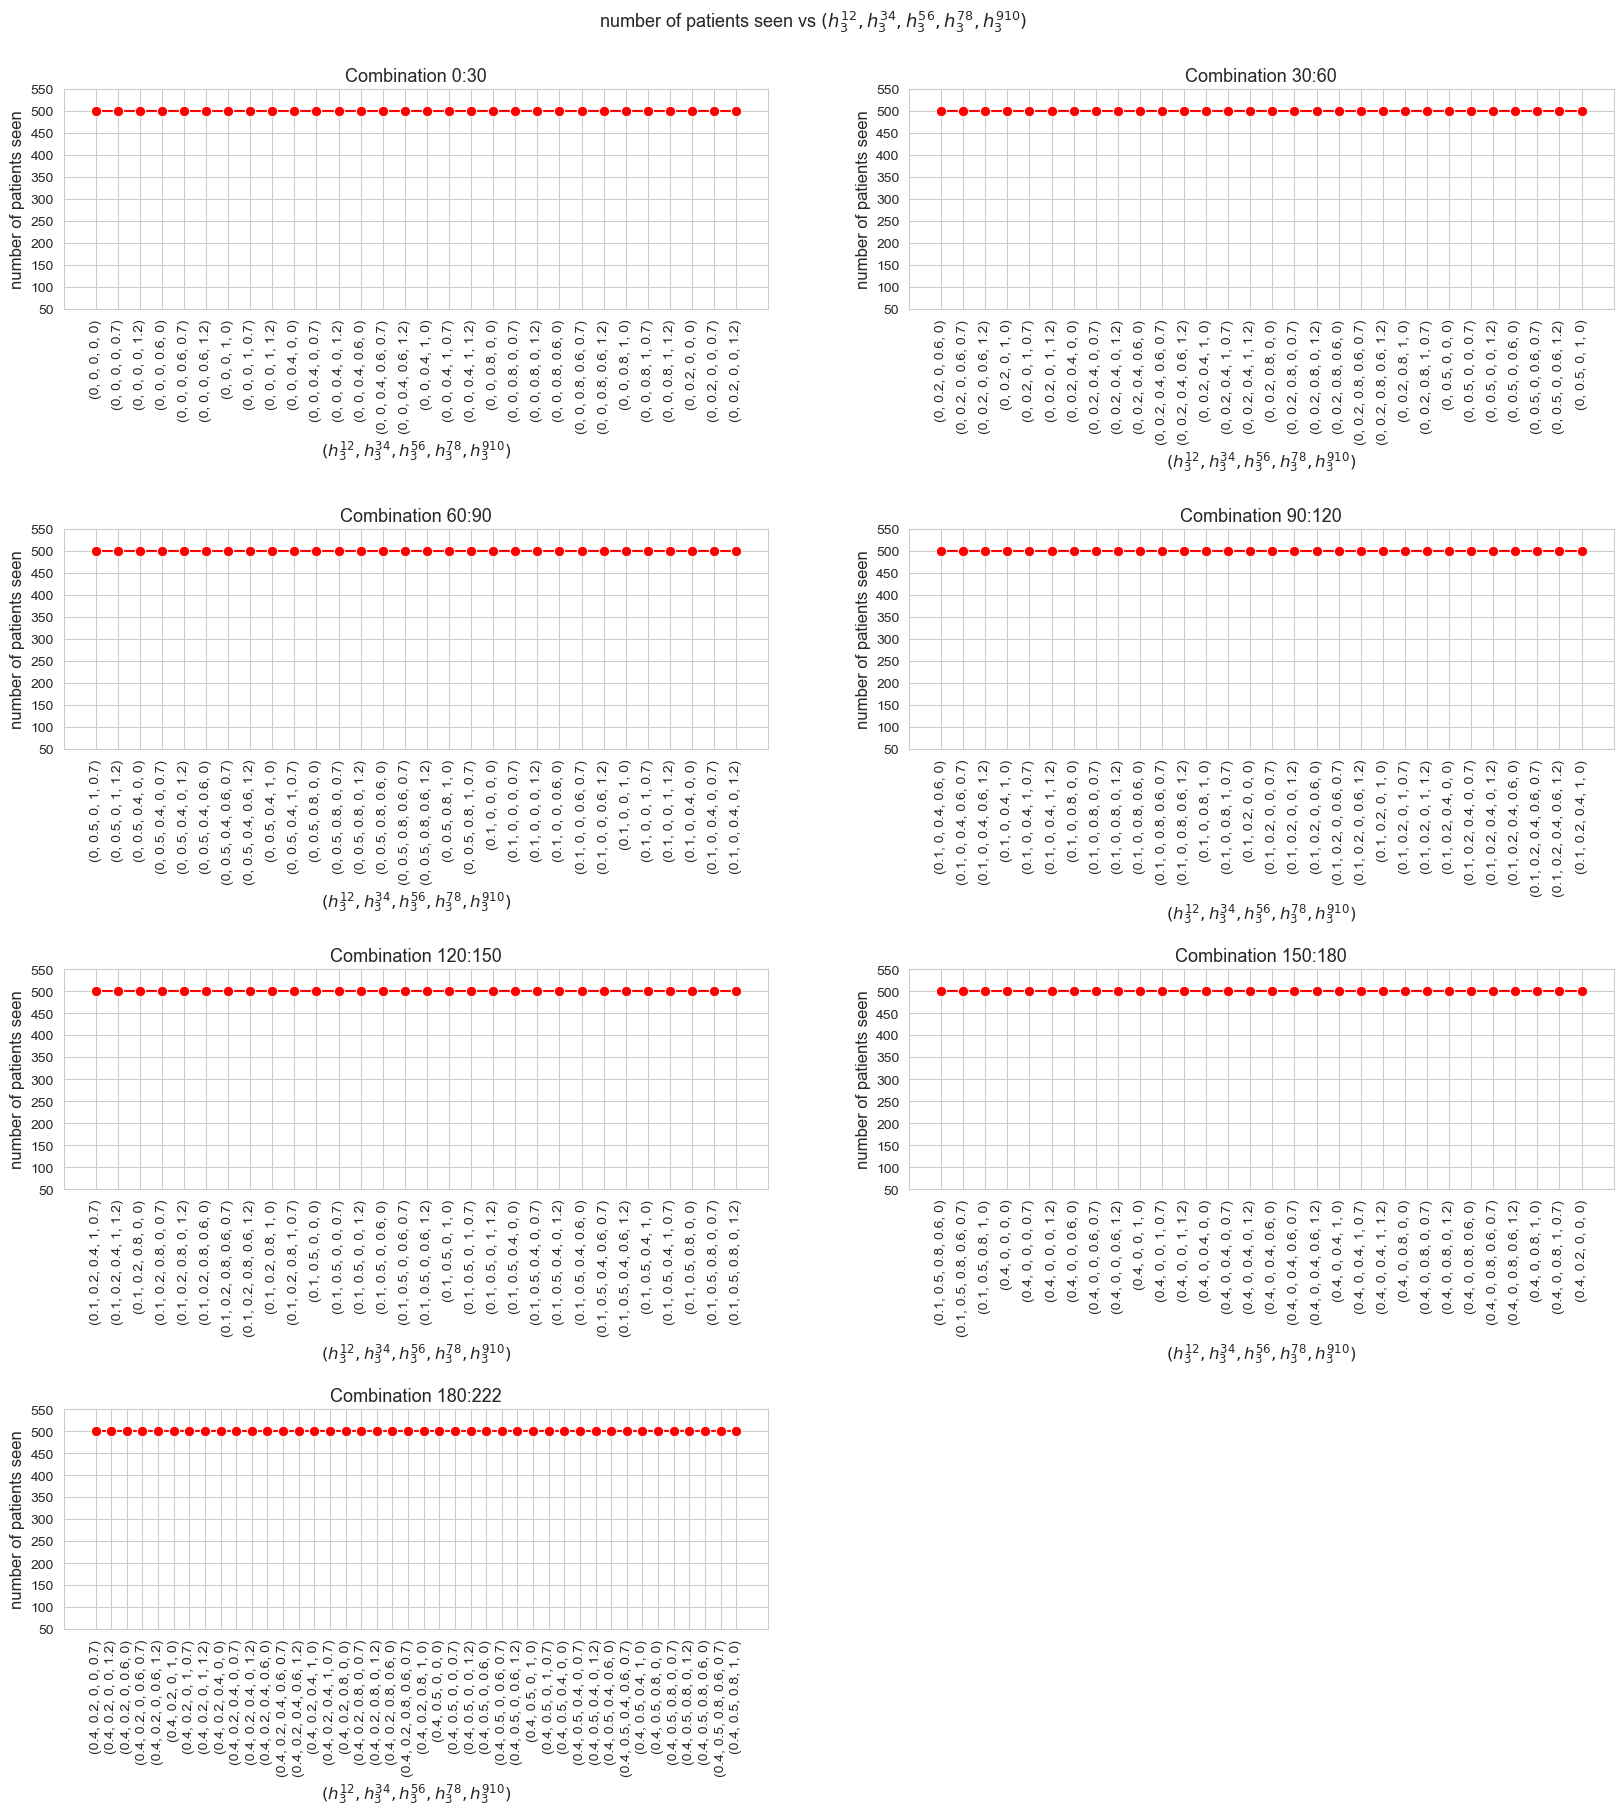

In [234]:
num_patients_seen_multi_plot(results2_multi=results2_multi, n_cols=2, figsize=(20, 20), interval_width=30)

**Interpretation of the results:**

In this case in all the cases the number of patients seen is the maximum possible $(p)$, since the new binary constraint enforce that.

- **Optimal value of the objective function vs $(h_3^{12}, h_3^{34}, h_3^{56}, h_3^{78}, h_3^{910})$**

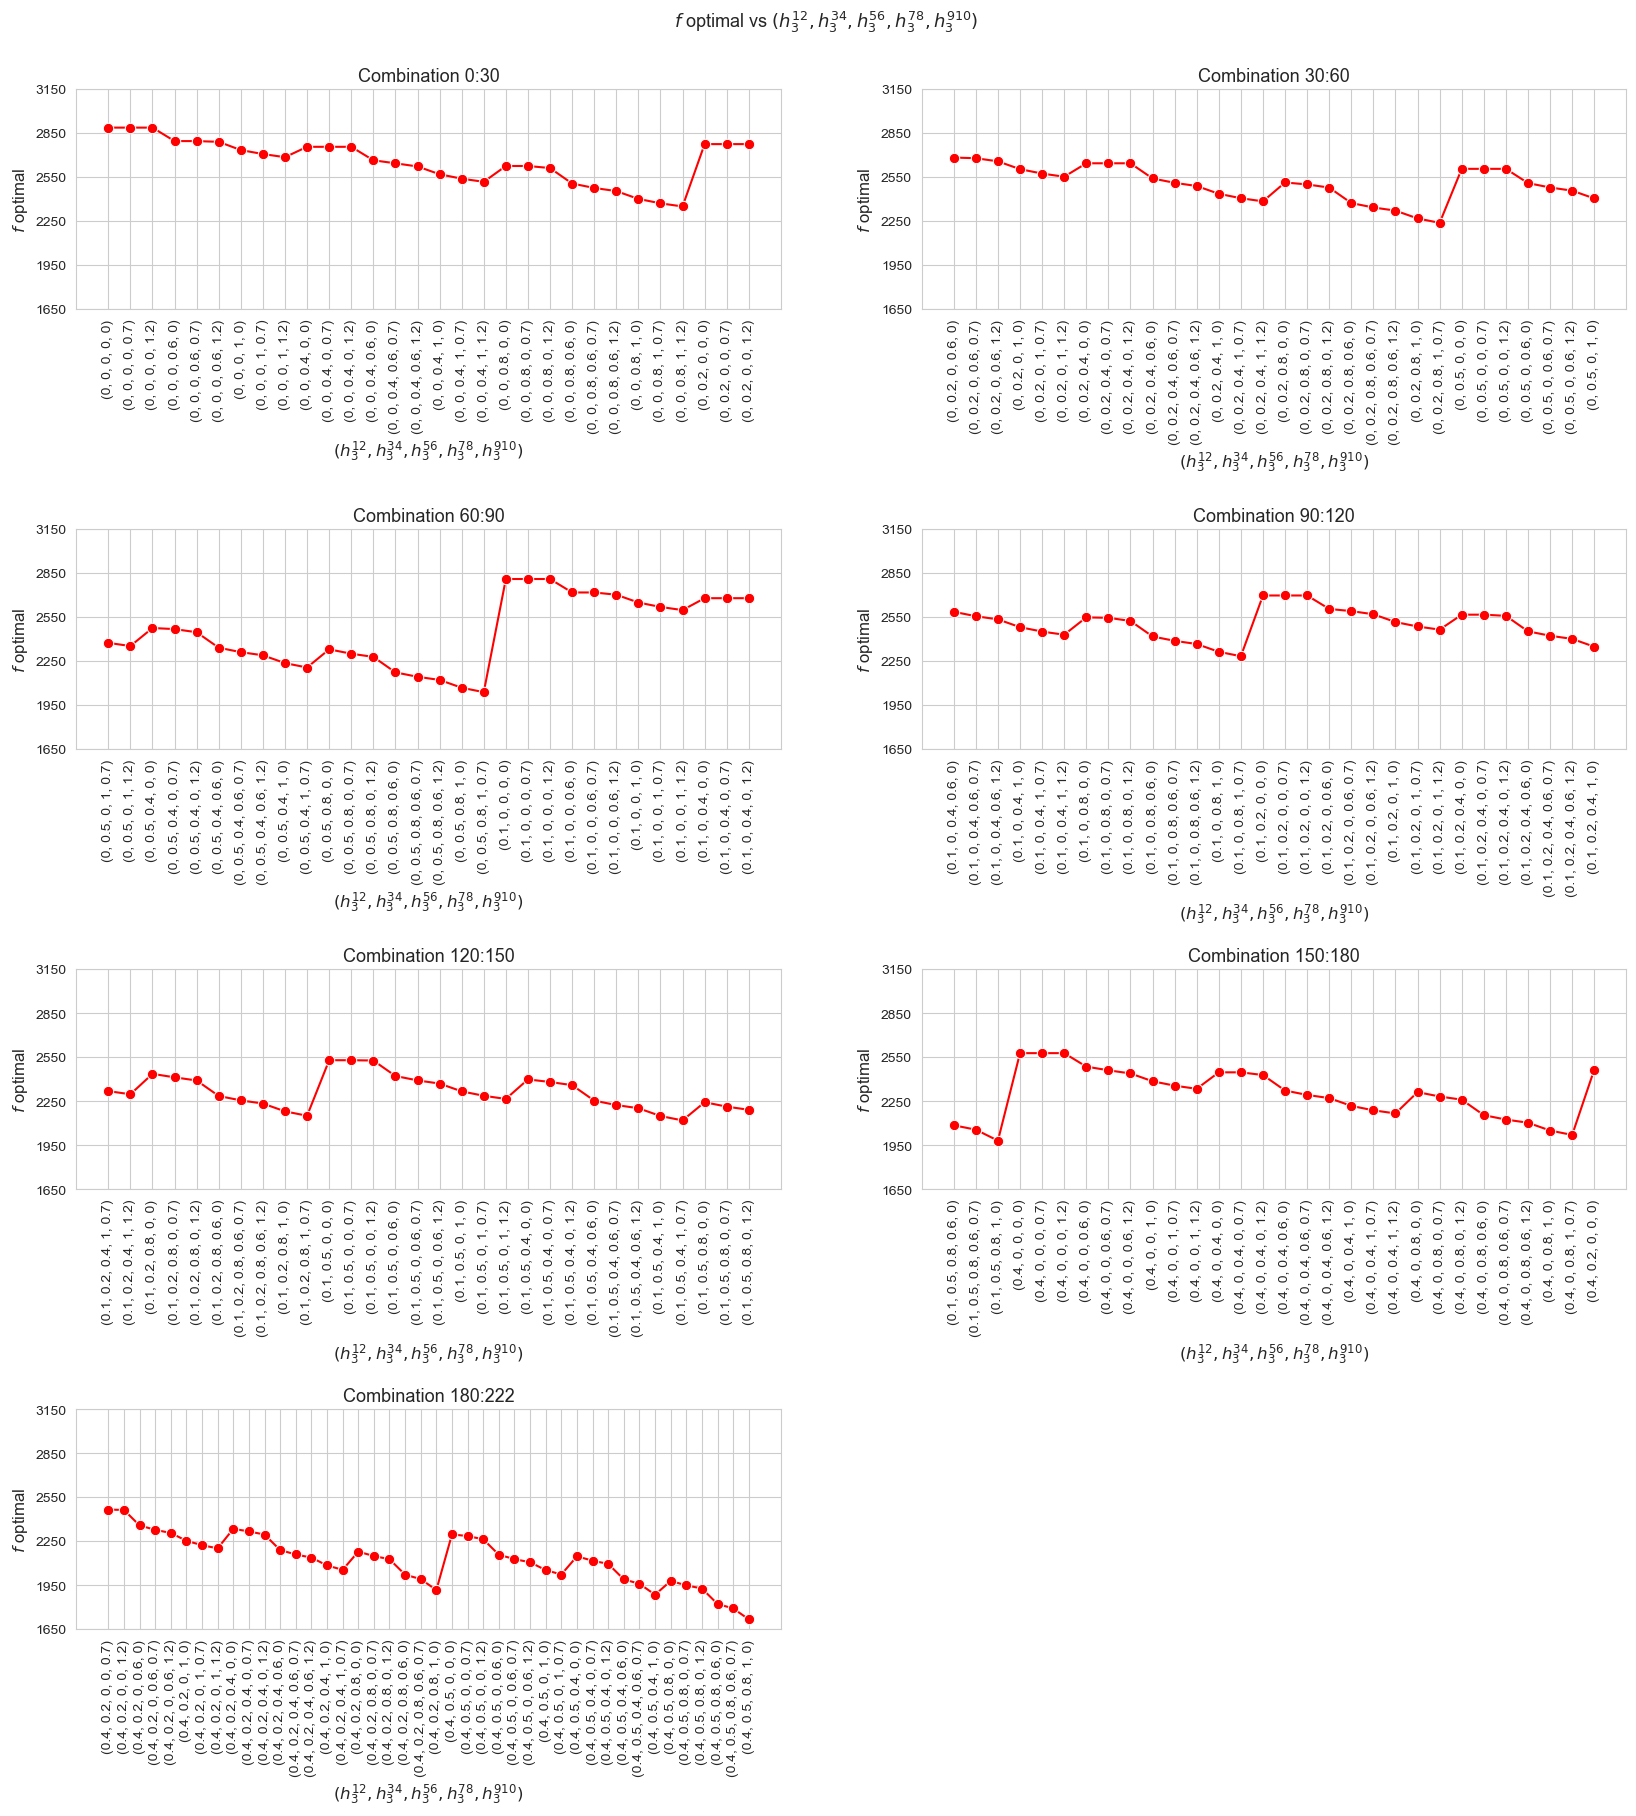

In [235]:
f_optimal_multi_plot(results2_multi=results2_multi, n_cols=2, figsize=(20, 20), interval_width=30)

**Interpretation of the results:**

Same interpretation to the one made for the linear model, because the results are the same.

- **Average time spent per patient vs $(h_3^{12}, h_3^{34}, h_3^{56}, h_3^{78}, h_3^{910})$**

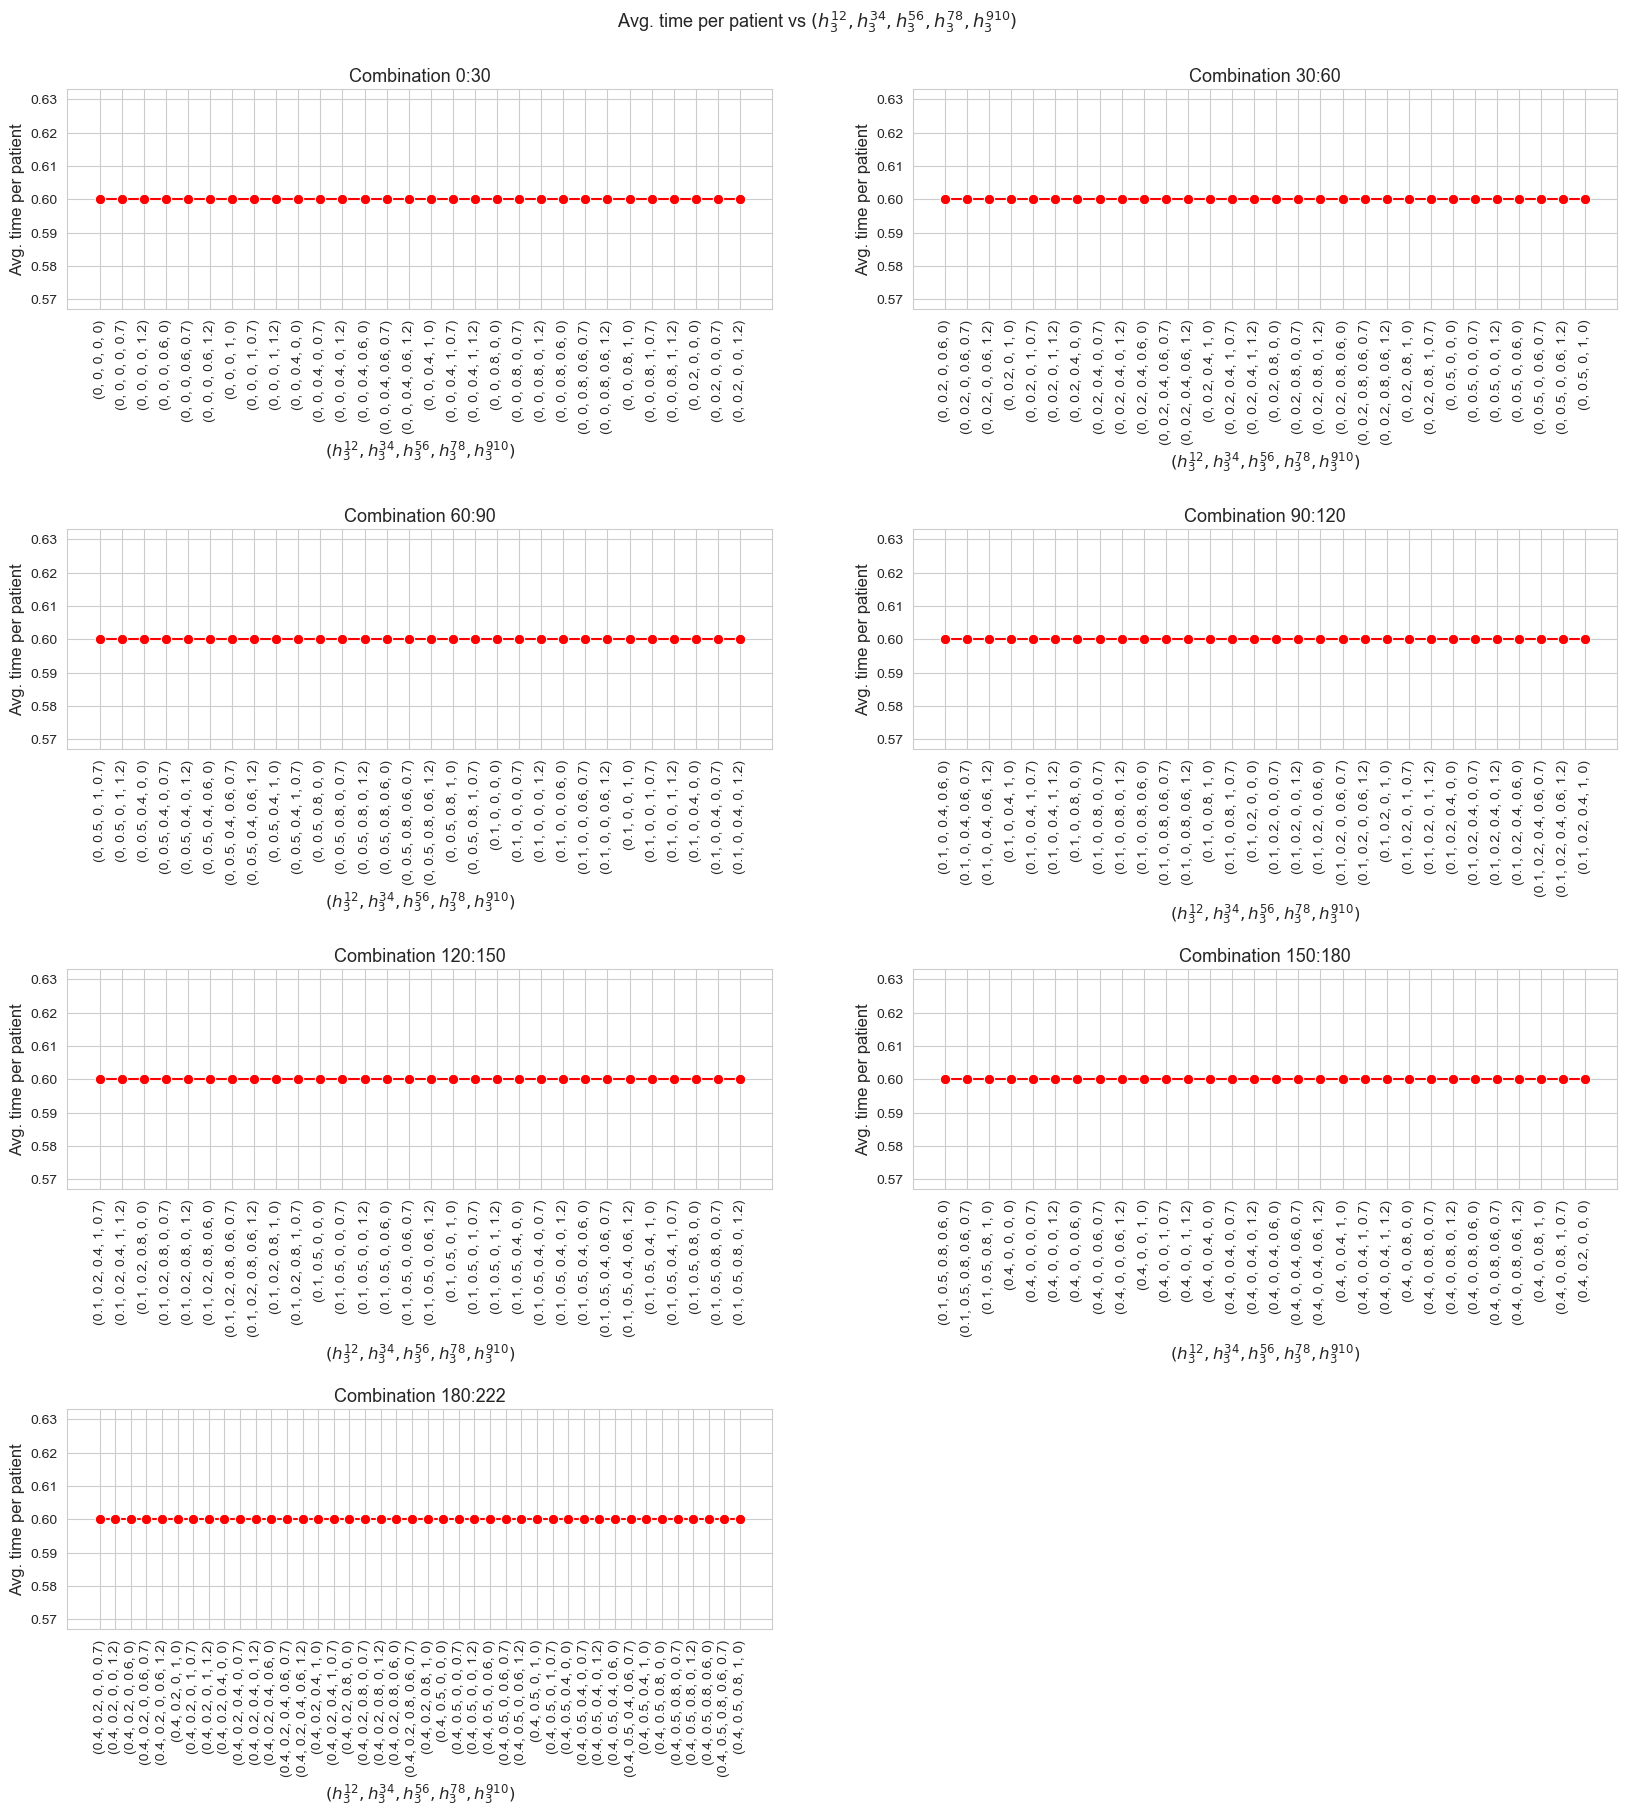

In [236]:
avg_time_multi_plot(results2_multi=results2_multi, n_cols=2, figsize = (20, 20), interval_width=30)

**Interpretation of the results:**

Same interpretation to the one made for the linear model, because the results are the same.

- **Median time spent per patient vs $(h_3^{12}, h_3^{34}, h_3^{56}, h_3^{78}, h_3^{910})$**

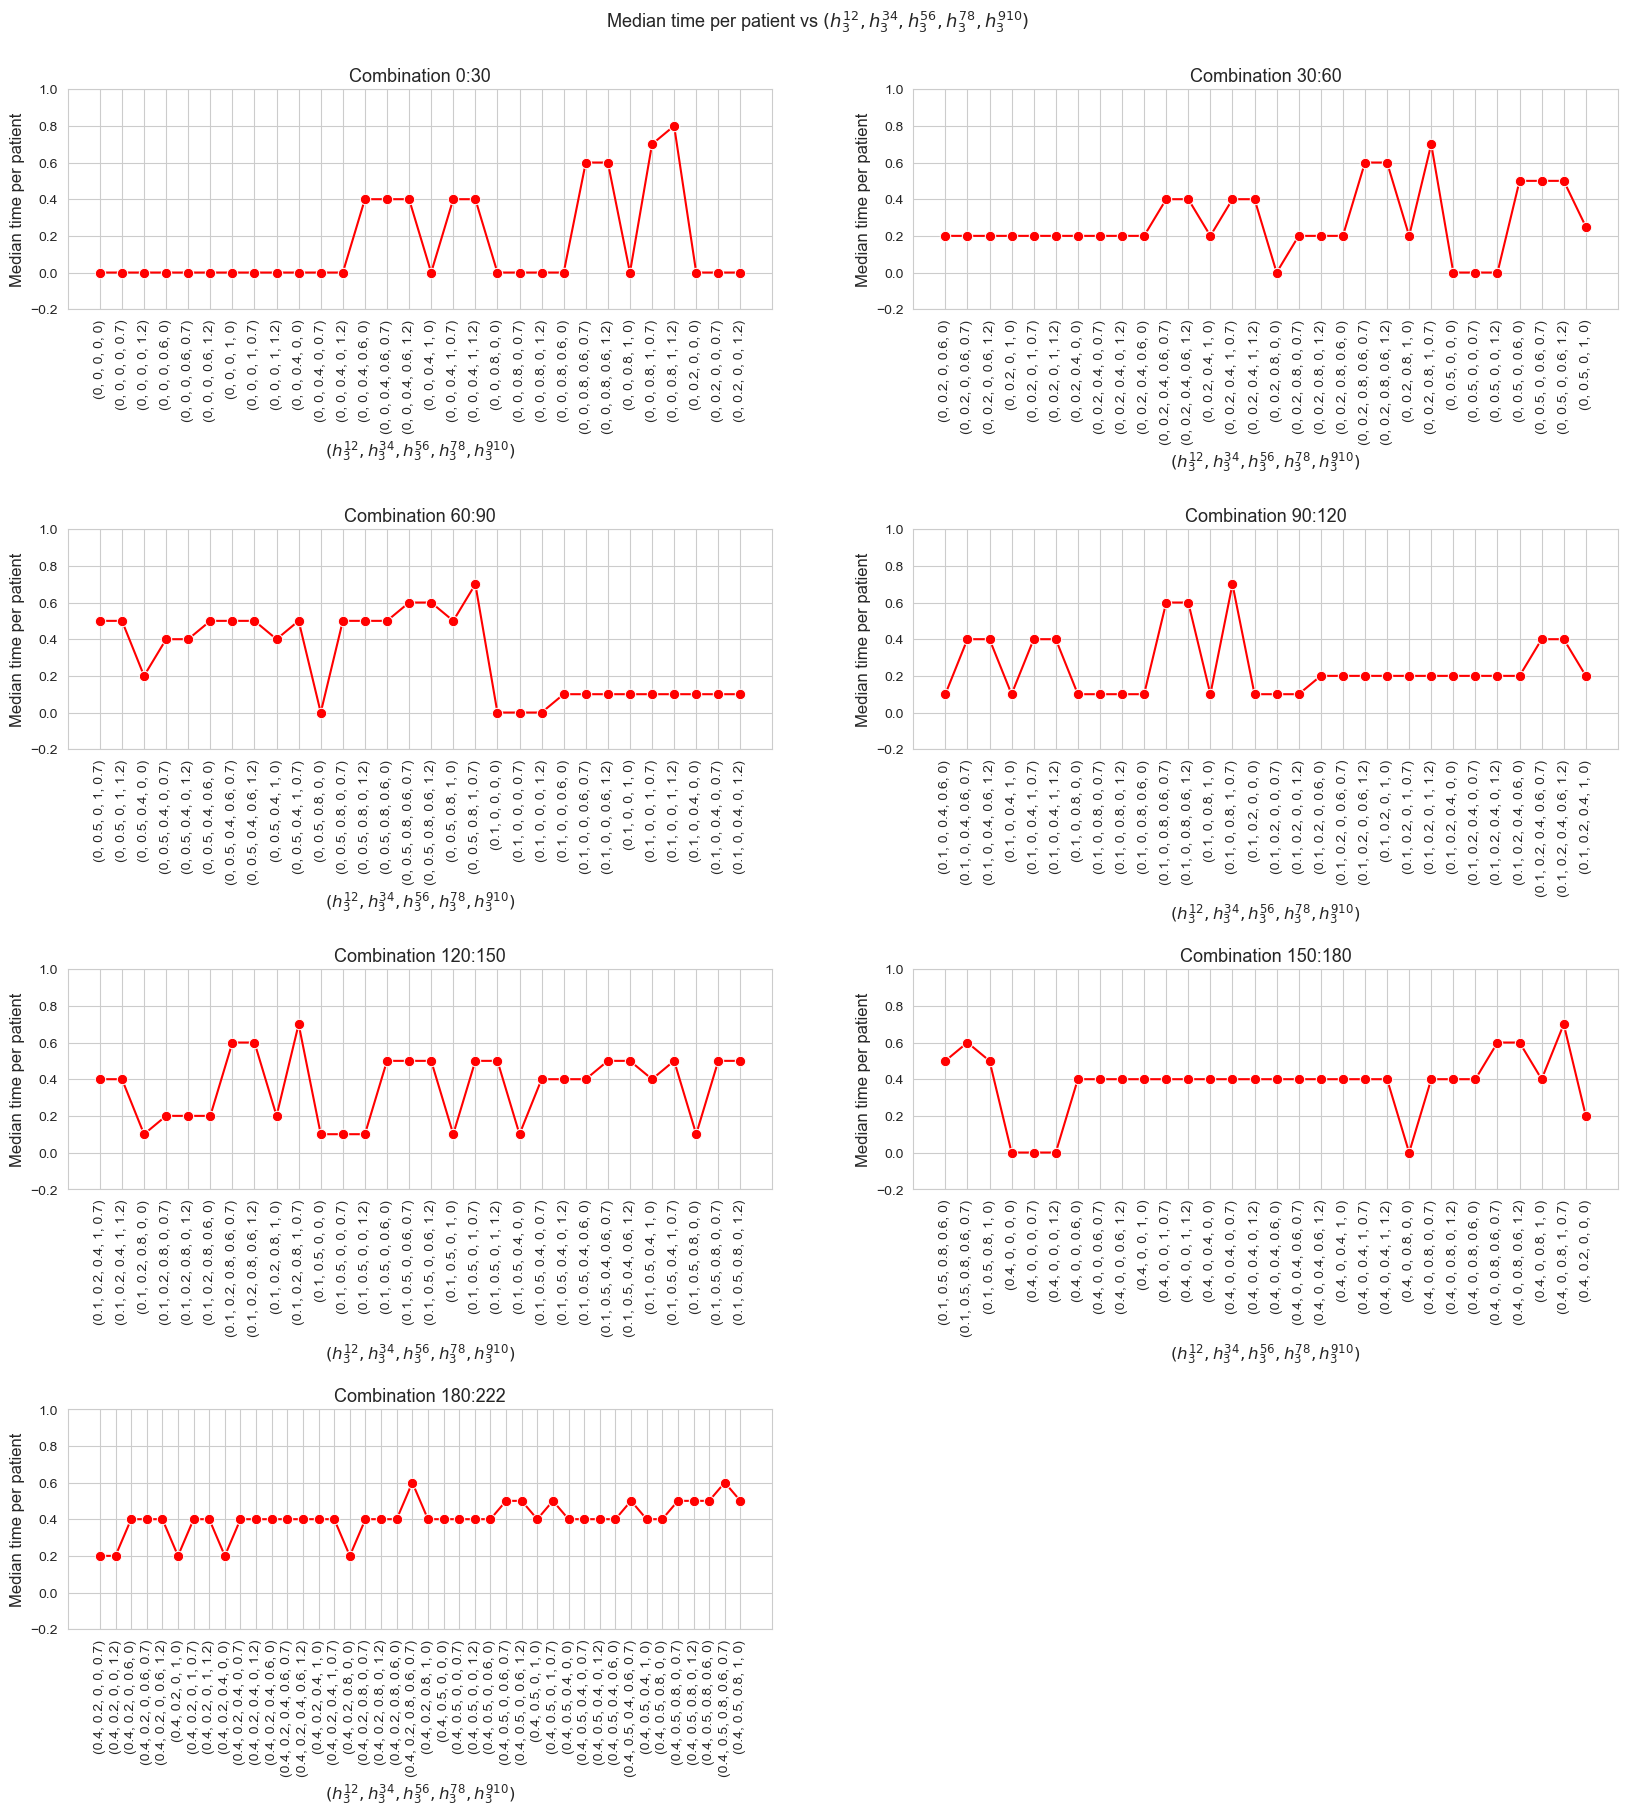

In [237]:
median_time_multi_plot(results2_multi=results2_multi, n_cols=2, figsize = (20, 20), interval_width=30)

**Interpretation of the results:**

Same interpretation to the one made for the linear model, because the results are the same.

- **$75$-quantile of time spent per patient vs $(h_3^{12}, h_3^{34}, h_3^{56}, h_3^{78}, h_3^{910})$**

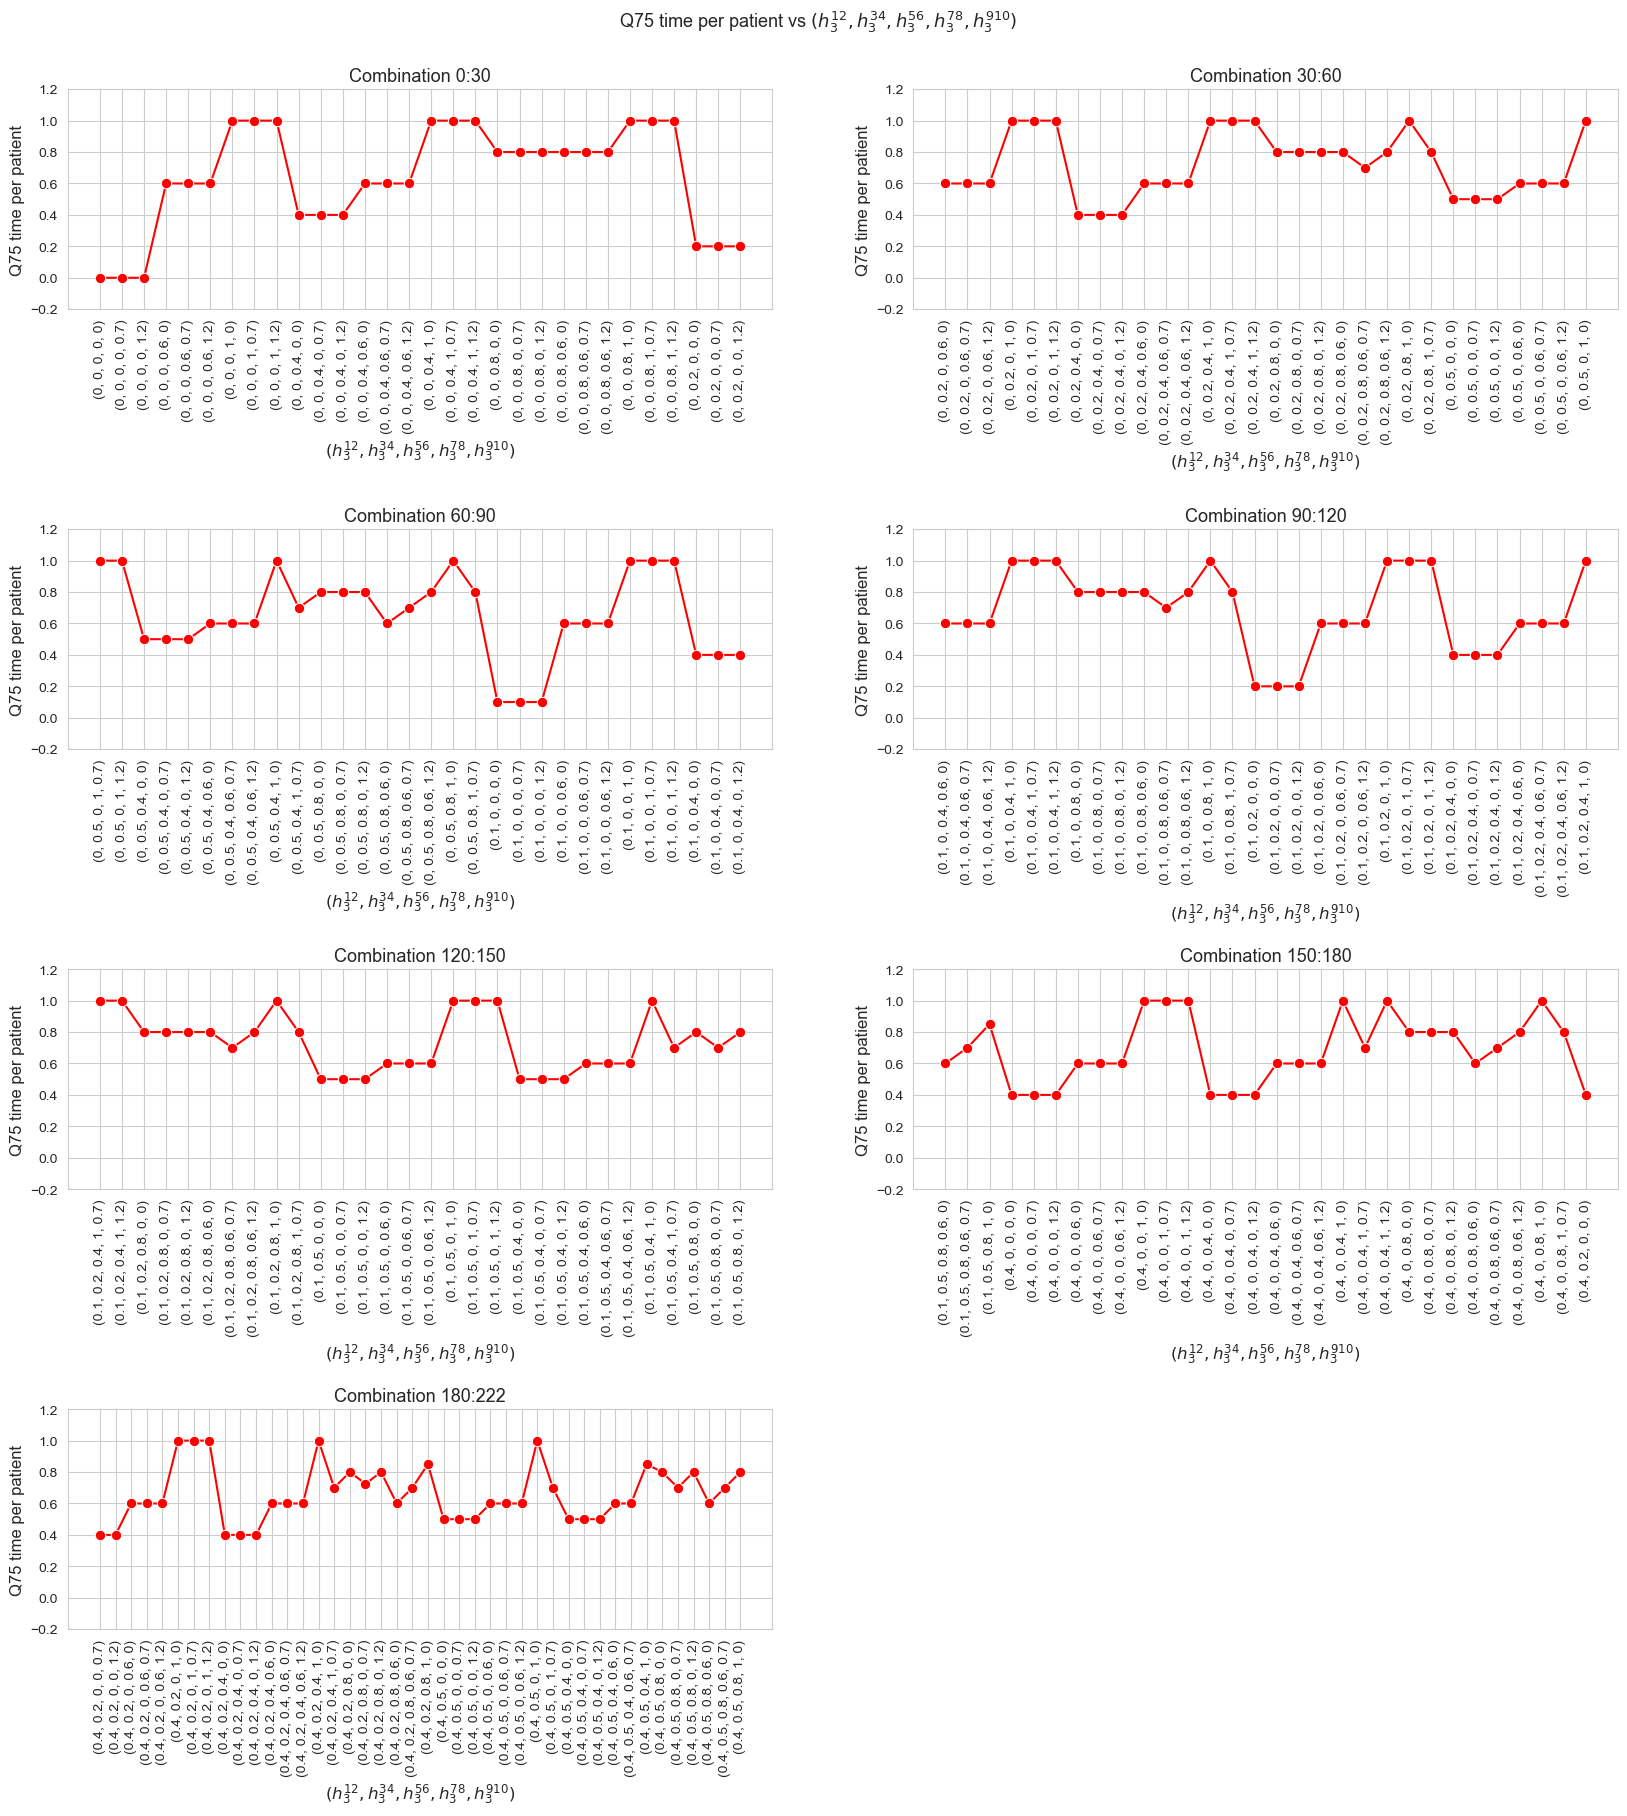

In [238]:
Q75_time_multi_plot(results2_multi=results2_multi, n_cols=2, figsize=(20, 20), interval_width=30)

**Interpretation of the results:**

Same interpretation to the one made for the linear model, because the results are the same.

- **$25$-quantile of time spent per patient vs $(h_3^{12}, h_3^{34}, h_3^{56}, h_3^{78}, h_3^{910})$**

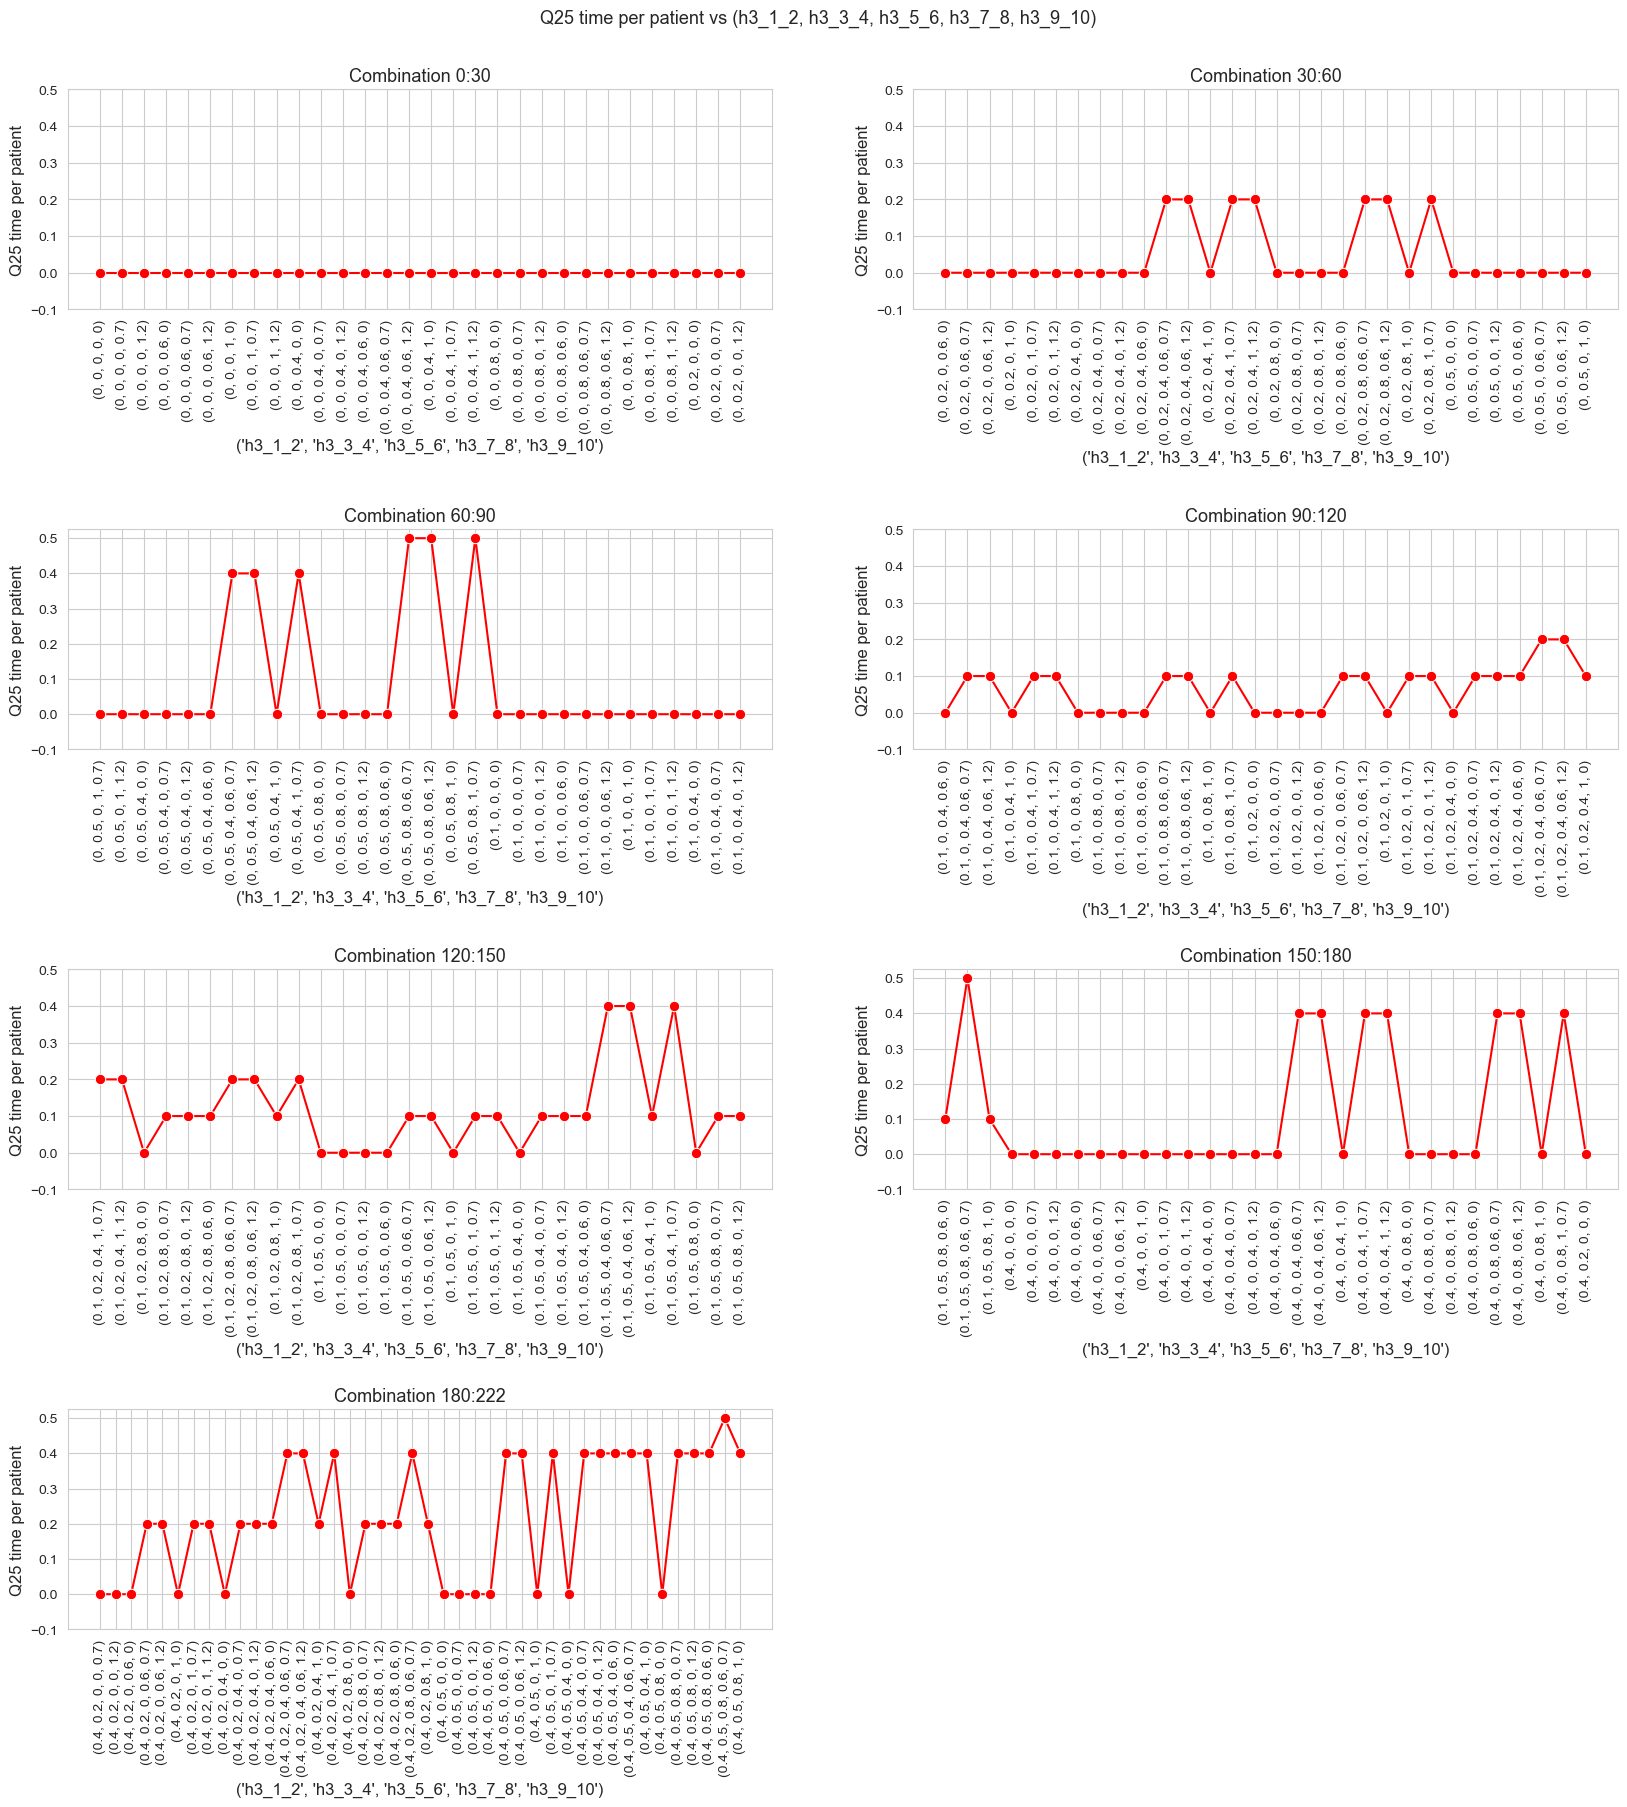

In [239]:
Q25_time_multi_plot(results2_multi=results2_multi, n_cols=2, figsize=(20, 20), interval_width=30)

**Interpretation of the results:**

Same interpretation to the one made for the linear model, because the results are the same.

- **Average time spent per patient vs $w$ vs $(h_3^{12}, h_3^{34}, h_3^{56}, h_3^{78}, h_3^{910})$**

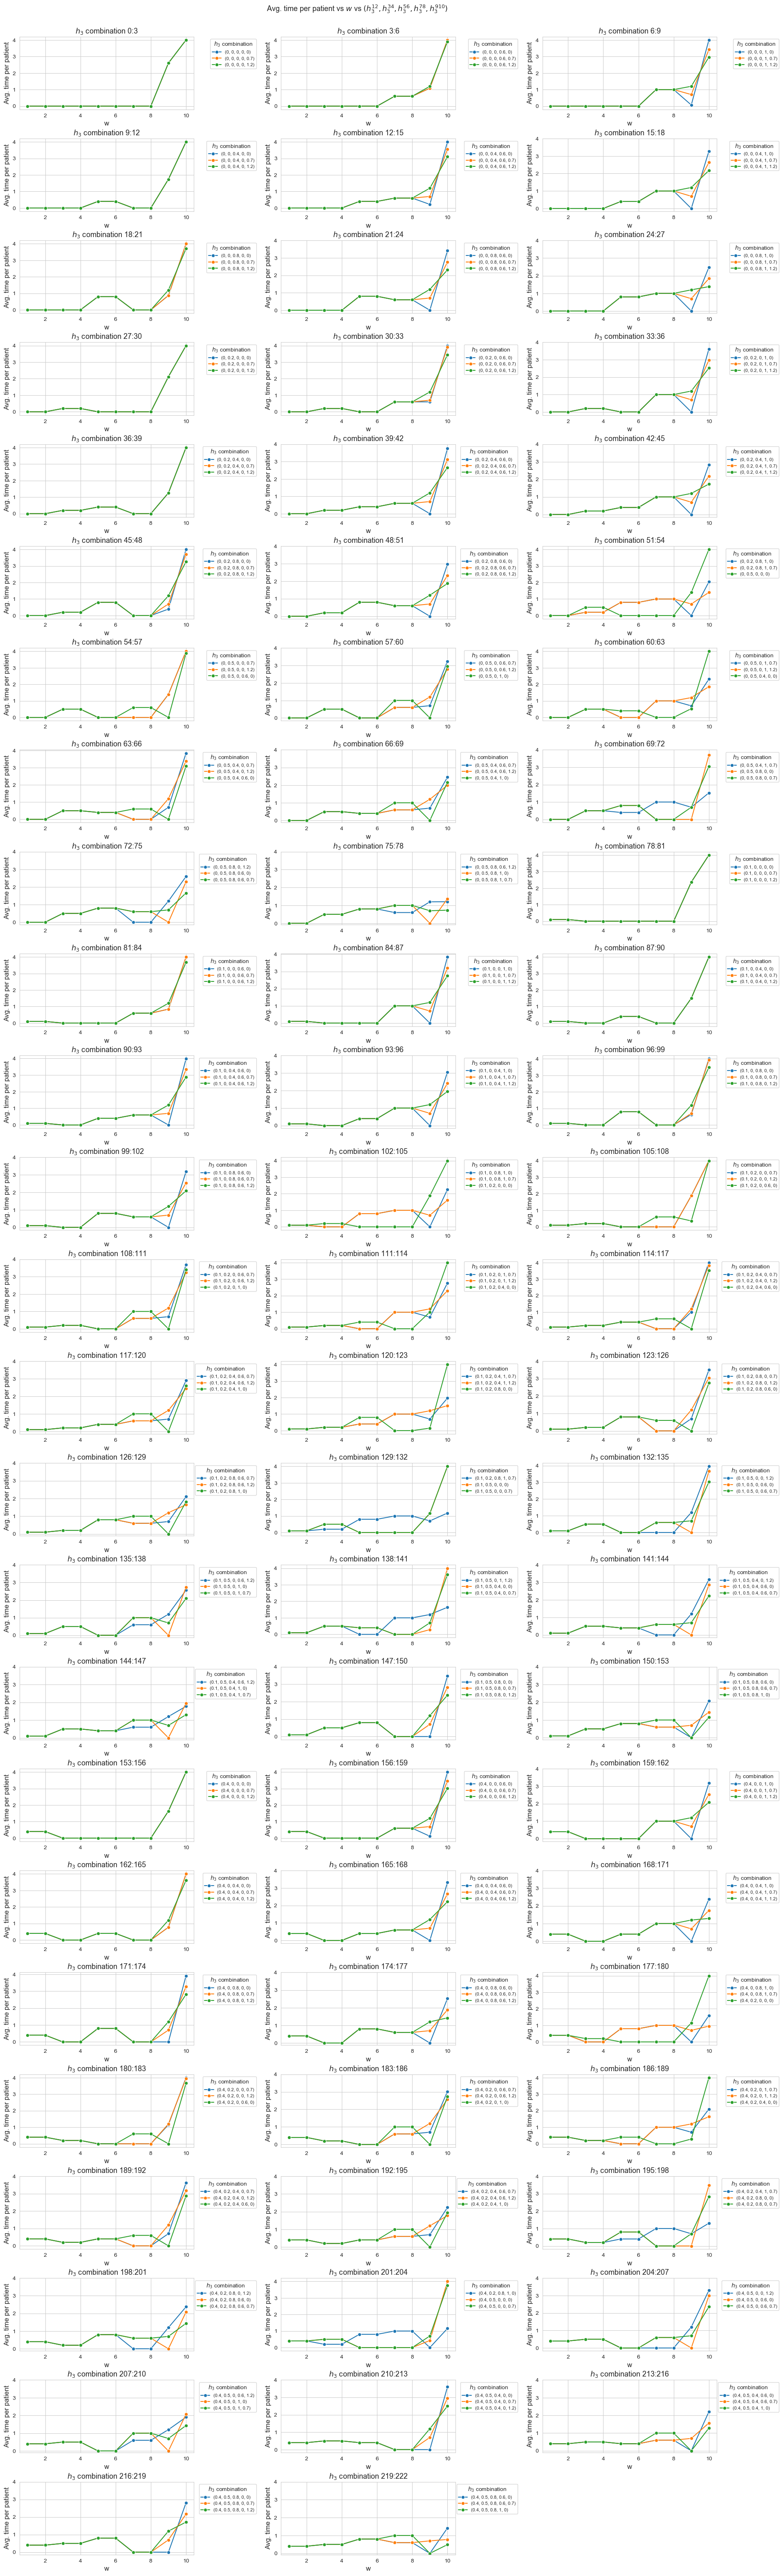

In [240]:
avg_time_w_multi_plot(results2_multi=results2_multi, n_cols = 3, figsize = (22, 80), interval_width=3)

**Interpretation of the results:**

Same interpretation to the one made for the linear model, because the results are the same.